<a href="https://colab.research.google.com/github/jwyangyin/TFM/blob/main/TFM_Notebook_2_(Master_Data_Science)_Sistema_de_recomendaci%C3%B3n_basado_en_contenido_(Content_Based_Filtering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>1. Introducción</h1>

<p>
En este cuaderno implementamos el <b>Sistema 2</b>: un <b>sistema de recomendación basado en contenido</b> para la categoría
<b>All_Beauty</b> del dataset <b>Amazon Reviews’23</b>. A diferencia del Sistema 1 (colaborativo Item-to-Item), aquí generamos recomendaciones
comparando <b>características del propio producto</b> (texto y metadatos), lo que permite mitigar parcialmente el problema de
<i>cold-start</i> cuando no existe suficiente historial de interacciones.
</p>

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
  <b>Objetivo práctico:</b> dado un producto (por <code>parent_asin</code>), recomendar otros productos <b>similares por contenido</b>
  (título, descripción, características, marca/categoría) mediante representaciones vectoriales y similitud coseno.
</div>

<p style="margin-top:10px;">
Para evitar duplicar contenido, la descripción detallada del dataset, su origen, y el diagnóstico de esparsidad/long-tail se encuentra en el
<b>Notebook del Sistema 1 (Item-to-Item)</b>. En este cuaderno reutilizamos las mismas fuentes y nos centramos en el modelado basado en contenido.
</p>

<br>
<h2>1.1. Fuentes de datos y estructura</h2>

<p>
Usamos los mismos ficheros del Sistema 1 (Amazon Reviews’23 – All_Beauty) descargados de:
<a href="https://amazon-reviews-2023.github.io/" target="_blank">https://amazon-reviews-2023.github.io/</a>.
</p>

<ul>
  <li><b>User Reviews</b> (<code>All_Beauty.jsonl</code>): interacciones usuario–producto (se usa de apoyo para análisis, no es el núcleo del modelo).</li>
  <li><b>Item Metadata</b> (<code>meta_All_Beauty.jsonl</code>): metadatos del producto (es el núcleo del enfoque basado en contenido).</li>
</ul>

<p>
La unidad de recomendación se mantiene a nivel de <b><code>parent_asin</code></b> (coherente con el Sistema 1) para agrupar variantes (<code>asin</code>)
y asegurar consistencia en el catálogo.
</p>


<br>
<h2>1.2. Carga de datos</h2>

<p>
Cargamos los ficheros del subconjunto <b>All_Beauty</b> en formato <b>JSONL</b> (un JSON por línea):
(i) reseñas de usuarios (<code>df_reviews</code>) y
(ii) metadatos de productos (<code>df_meta</code>).
Dado el tamaño de ambos ficheros, la lectura se realiza de forma <b>secuencial</b> para reducir el consumo de memoria y garantizar estabilidad en el entorno de ejecución.
</p>

<p>
Tras la carga, se realizan comprobaciones básicas de integridad: número de filas, columnas disponibles y presencia de la clave
<code>parent_asin</code>, que actúa como identificador de producto y permite enlazar reseñas y metadatos de forma consistente.
</p>

<p>
A diferencia del <b>Sistema 1 (Item-to-Item)</b>, donde la carga de datos se orientaba a la construcción de la matriz usuario–ítem,
en este <b>Sistema 2 (basado en contenido)</b> el foco está en preparar el catálogo de productos para su posterior análisis
mediante atributos y texto. El proceso de limpieza, selección de campos y análisis exploratorio específico de contenido
se desarrolla en los apartados siguientes.
</p>


In [1]:
# Montamos Google Drive en Colab:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importamos las librerías necesarias:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Rutas (ajusta si tu estructura es distinta):
path_reviews = "/content/drive/My Drive/Colab Notebooks/All_Beauty.jsonl"
path_meta    = "/content/drive/My Drive/Colab Notebooks/meta_All_Beauty.jsonl"

def read_jsonl(path: str, max_rows: int = None) -> pd.DataFrame:
    """
    Lee un JSONL (un JSON por línea) de forma secuencial para reducir memoria.
    - max_rows: si quieres cargar solo una parte (debug). None = todo.
    """
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_rows is not None and i >= max_rows:
                break
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

In [3]:
# Mostramos las primeras 5 líneas del dataset df_reviews:
df_reviews = read_jsonl(path_reviews)
df_reviews.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [4]:
# Mostramos las primeras 5 líneas del dataset df_meta:
df_meta = read_jsonl(path_meta)
df_meta.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Howard Products,[],{'Package Dimensions': '7.1 x 5.5 x 3 inches; ...,B01CUPMQZE,None
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Yes To,[],"{'Item Form': 'Powder', 'Skin Type': 'Acne Pro...",B076WQZGPM,None
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Levine Health Products,[],{'Manufacturer': 'Levine Health Products'},B000B658RI,None
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Cherioll,[],"{'Brand': 'Cherioll', 'Item Form': 'Powder', '...",B088FKY3VD,None
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,"[Material: 304 Stainless Steel; Brass tip, Len...",[The Precision Plunger Bars are designed to wo...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Precision,[],{'UPC': '644287689178'},B07NGFDN6G,None


In [5]:
# --- Realizamos chequeos básicos ---
print("Dimensiones cargadas:")
print("df_reviews shape:", df_reviews.shape)
print("df_meta    shape:", df_meta.shape)

print("\nColumnas df_reviews:", list(df_reviews.columns))
print("\nColumnas df_meta:", list(df_meta.columns))

Dimensiones cargadas:
df_reviews shape: (701528, 10)
df_meta    shape: (112590, 14)

Columnas df_reviews: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

Columnas df_meta: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']


In [6]:
# Clave mínima para enlazar parent_asin:
assert "parent_asin" in df_reviews.columns, "Falta 'parent_asin' en df_reviews."
assert "parent_asin" in df_meta.columns, "Falta 'parent_asin' en df_meta."

print("\nOK: 'parent_asin' presente en ambos datasets.")


OK: 'parent_asin' presente en ambos datasets.


<br>
<h2>1.3. Contexto de los datos</h2>

<p>
Este segundo sistema utiliza el mismo dominio y fuentes que el <b>Sistema 1 (Item-to-Item)</b> (Amazon Reviews’23,
subconjunto <b>All Beauty</b>): un fichero de <i>reviews</i> (interacciones) y un fichero de <i>metadatos</i> (catálogo).
La diferencia clave es el objetivo: aquí modelamos similitud entre productos a partir de sus <b>atributos</b> y/o <b>texto</b>,
por lo que el dataset central es <code>df_meta</code> y las <code>reviews</code> se usan como soporte para validaciones y escenarios de uso.
</p>

<ul>
  <li><b>df_reviews (interacciones):</b> reseñas con <code>user_id</code>, <code>parent_asin</code>, <code>rating</code> y <code>timestamp</code>.
      En este sistema se emplea principalmente para: (i) definir histórico/semillas de usuario en demos, y (ii) evaluación/validación si se aplica un protocolo offline.</li>
  <li><b>df_meta (catálogo):</b> información del producto indexada por <code>parent_asin</code>.
      Es la base del recomendador de contenido, ya que aporta los campos informativos para construir la representación de cada ítem
      (p. ej., <code>title</code>, <code>description</code>, <code>features</code>, <code>brand</code>, <code>categories</code>, según disponibilidad real).</li>
</ul>

<p>
Es decir:
</p>

<h3>A) Variables de interacción (User Reviews) — 10 campos</h3>

In [7]:
# Variables del dataset de reseñas:
print("Variables (User Reviews):",list(df_reviews.columns))
print("Número de variables (User Reviews):", df_reviews.shape[1])

Variables (User Reviews): ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']
Número de variables (User Reviews): 10


<table style="width:100%; border-collapse:collapse;">
  <thead>
    <tr style="background:#f2f2f2;">
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Campo</th>
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Tipo</th>
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>rating</code></td><td style="padding:8px; border:1px solid #ddd;">float</td><td style="padding:8px; border:1px solid #ddd;">Valoración del producto (de 1.0 a 5.0).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>title</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Título de la reseña escrita por el usuario.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>text</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Cuerpo (texto completo) de la reseña del usuario.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>images</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Lista de imágenes aportadas por el usuario (URLs en distintos tamaños).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>asin</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Identificador del producto (a nivel de variante/SKU).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>parent_asin</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Identificador “padre” que agrupa variantes (color, talla, estilo).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>user_id</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Identificador anónimo del usuario que escribe la reseña.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>timestamp</code></td><td style="padding:8px; border:1px solid #ddd;">int</td><td style="padding:8px; border:1px solid #ddd;">Momento de la reseña (tiempo Unix).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>verified_purchase</code></td><td style="padding:8px; border:1px solid #ddd;">bool</td><td style="padding:8px; border:1px solid #ddd;">Indicador de compra verificada del usuario.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>helpful_vote</code></td><td style="padding:8px; border:1px solid #ddd;">int</td><td style="padding:8px; border:1px solid #ddd;">Número de votos de utilidad (“helpful votes”) de la reseña.</td></tr>
  </tbody>
</table>

<h3>B) Variables de producto (Item Metadata) — 14 campos</h3>

In [8]:
# Variables del dataset de metadatos:
print("Variables (Item Metadata):",list(df_meta.columns))
print("Número de variables (Item Metadata):", df_meta.shape[1])

Variables (Item Metadata): ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']
Número de variables (Item Metadata): 14


<table style="width:100%; border-collapse:collapse;">
  <thead>
    <tr style="background:#f2f2f2;">
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Campo</th>
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Tipo</th>
      <th style="text-align:left; padding:8px; border:1px solid #ddd;">Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>main_category</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Categoría principal (dominio) del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>title</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Nombre del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>average_rating</code></td><td style="padding:8px; border:1px solid #ddd;">float</td><td style="padding:8px; border:1px solid #ddd;">Valoración media mostrada en la página del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>rating_number</code></td><td style="padding:8px; border:1px solid #ddd;">int</td><td style="padding:8px; border:1px solid #ddd;">Número total de valoraciones del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>features</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Características en formato viñetas (“bullet points”).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>description</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Descripción del producto (habitualmente en lista).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>price</code></td><td style="padding:8px; border:1px solid #ddd;">float</td><td style="padding:8px; border:1px solid #ddd;">Precio en dólares estadounidenses (en el momento del crawling).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>images</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Imágenes del producto (thumb/large/hi_res) y su “variant”.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>videos</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Vídeos del producto (título y URL).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>store</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Nombre de la tienda/vendedor del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>categories</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Categorías jerárquicas del producto.</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>details</code></td><td style="padding:8px; border:1px solid #ddd;">dict</td><td style="padding:8px; border:1px solid #ddd;">Detalles del producto (marca, material, tamaños, etc.).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>parent_asin</code></td><td style="padding:8px; border:1px solid #ddd;">str</td><td style="padding:8px; border:1px solid #ddd;">Identificador “padre” del producto (clave para unir con reseñas).</td></tr>
    <tr><td style="padding:8px; border:1px solid #ddd;"><code>bought_together</code></td><td style="padding:8px; border:1px solid #ddd;">list</td><td style="padding:8px; border:1px solid #ddd;">Bundles recomendados (“frecuentemente comprados juntos”).</td></tr>
  </tbody>
</table>

<br>
<h2>1.4. Estadísticas básicas del subconjunto All_Beauty</h2>

<p>
Como primer diagnóstico, resumimos el tamaño del problema en el subconjunto <b>All_Beauty</b> usando:
(i) <code>df_reviews</code> (interacciones) y (ii) <code>df_meta</code> (catálogo). En este Sistema 2 (contenido),
estas magnitudes nos sirven para dimensionar el catálogo a representar (por <code>parent_asin</code>) y anticipar
retos de cobertura textual.
</p>

<ul>
  <li><b>Reseñas (interacciones)</b>: 701.528</li>
  <li><b>Usuarios únicos</b>: 631.986</li>
  <li><b>Ítems únicos</b> (por <code>parent_asin</code>, desde <code>df_reviews</code>): 112.565</li>
  <li><b>Filas de catálogo</b> (productos en <code>df_meta</code>): 112.590</li>
  <li><b><code>parent_asin</code> únicos</b> en <code>df_meta</code>: 112.590</li>
</ul>

</p>

In [9]:
# Estadísticas básicas desde df_reviews:
n_reviews = df_reviews.shape[0]                      # nº de interacciones (filas)
n_users = df_reviews["user_id"].nunique()            # usuarios únicos
n_items_parent = df_reviews["parent_asin"].nunique() # ítems únicos (por parent_asin)

print("Estadísticas básicas (All_Beauty - User Reviews):")
print(f"- Reseñas (interacciones): {n_reviews:,}".replace(",", "."))
print(f"- Usuarios únicos: {n_users:,}".replace(",", "."))
print(f"- Ítems únicos (por parent_asin): {n_items_parent:,}".replace(",", "."))

Estadísticas básicas (All_Beauty - User Reviews):
- Reseñas (interacciones): 701.528
- Usuarios únicos: 631.986
- Ítems únicos (por parent_asin): 112.565


In [10]:
# Mostramos las estadísticas básicas desde df_meta:
n_rows_meta = df_meta.shape[0]
n_items_meta = df_meta["parent_asin"].nunique()

print("\nEstadísticas básicas (All_Beauty - Item Metadata):")
print(f"- Filas (productos): {n_rows_meta:,}".replace(",", "."))
print(f"- parent_asin únicos: {n_items_meta:,}".replace(",", "."))


Estadísticas básicas (All_Beauty - Item Metadata):
- Filas (productos): 112.590
- parent_asin únicos: 112.590


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<b>Implicación práctica:</b> el volumen de usuarios e interacciones es grande, pero el dominio es altamente disperso (long-tail),
por lo que muchas entidades tienen poca evidencia en comportamiento. A diferencia del Sistema 1 (colaborativo),
aquí el foco no es construir co-ocurrencias usuario–ítem, sino asegurar que el catálogo (<code>df_meta</code>) dispone de
atributos/texto suficientes para construir una representación por producto. Por ello, en el EDA específico de contenido
analizaremos la <b>cobertura y calidad del texto</b> (campos disponibles, nulos, longitudes y proporción de productos con
información útil).
</div>

<hr>
<br>
<h1>2. Enfoque del modelo: Recomendación basada en contenido</h1>

<p>
En este segundo sistema aplicamos un <b>enfoque de recomendación basada en contenido (Content-Based Filtering)</b>.
A diferencia del Sistema 1 (filtrado colaborativo Item-to-Item), donde las recomendaciones se derivan de
<b>patrones de co-ocurrencia entre usuarios y productos</b>, aquí el objetivo es <b>modelar la similitud entre productos
a partir de sus propias características</b>.
</p>


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
La idea central es sencilla: <b>dos productos son similares si comparten atributos descriptivos parecidos</b>,
como el título, la descripción, las características del producto, la marca o la categoría. De este modo, podemos
recomendar productos <b>incluso cuando no existen interacciones previas suficientes</b>, mitigando parcialmente el
problema de <i>cold-start</i>.
</div>


<br/>

<h2>2.1. Intuición del enfoque</h2>

<p>
Si observamos dos productos que presentan descripciones textuales similares —por ejemplo, comparten ingredientes,
tipo de uso o categoría cosmética—, interpretamos que dichos productos están relacionados desde el punto de vista del contenido.
</p>

<p>
Por tanto, cuando un usuario interactúa con un producto concreto (o cuando queremos encontrar productos alternativos a uno dado),
podemos recomendar <b>otros productos con contenido similar</b>, sin necesidad de apoyarnos en el comportamiento de otros usuarios.
</p>>


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;"><b>Regla práctica:</b>
“Dado un producto A, recomendamos productos cuyo contenido sea más similar al de A”.
</div>

<p>Este enfoque resulta especialmente adecuado en escenarios donde:</p>
<ul>
  <li>hay <b>muchos productos con pocas interacciones</b>,</li>
  <li>los usuarios tienen historiales cortos o inexistentes,</li>
  <li>o se desea ofrecer recomendaciones explicables basadas en atributos del producto.</li>
</ul>

<br>

<h2>2.2. Representación de los datos</h2>

<p>
En el sistema basado en contenido, el objeto central de modelado es el <b>ítem</b>, no el usuario. Cada producto se
representa mediante un conjunto de <b>atributos descriptivos</b>, principalmente de tipo textual.
</p>

<p>
A nivel conceptual, transformamos cada producto en un <b>“documento”</b>, construido a partir de los campos disponibles
en <code>df_meta</code>, tales como:
</p>

<ul>
  <li><code>title</code></li>
  <li><code>description</code></li>
  <li><code>features</code></li>
  <li><code>brand</code></li>
  <li><code>categories</code></li>
  <li>(según disponibilidad real en el dataset)</li>
</ul>

<p>
Estos campos se combinan y procesan para obtener una <b>representación vectorial</b> de cada producto, que permita comparar
ítems entre sí de forma cuantitativa.
</p>

<p>
Las interacciones (<code>df_reviews</code>) no se utilizan para construir el modelo de similitud, sino como <b>soporte para demos,
validaciones y escenarios de evaluación</b>.
</p>

<br>

<h2>2.3. Cálculo de similitud entre ítems</h2>

<p>
Una vez obtenida la representación vectorial de cada producto, calculamos una <b>matriz de similitud ítem-ítem basada en contenido</b>.
</p>

<p>
La similitud mide hasta qué punto dos productos son parecidos <b>en términos de sus atributos</b>, no de su consumo conjunto por usuarios.
Una opción habitual y ampliamente utilizada es la <b>similitud del coseno</b>, que compara el ángulo entre los vectores de contenido de dos productos.
</p>

<p>
Intuitivamente:
</p>
<ul>
  <li>productos con descripciones muy parecidas tendrán similitud alta,</li>
  <li>productos con contenido distinto tendrán similitud baja.</li>
</ul>

<p>
Este cálculo se realiza sobre matrices potencialmente grandes, por lo que se emplean <b>representaciones eficientes</b>
(por ejemplo, matrices dispersas) para mantener un coste computacional razonable.
</p>

<br>

<h2>2.4. Generación de recomendaciones</h2>

<p>La generación de recomendaciones sigue un esquema directo:</p>
<ol>
  <li>Seleccionamos un <b>producto de referencia</b> (por ejemplo, un <code>parent_asin</code>).</li>
  <li>Recuperamos los <b>productos más similares por contenido</b> según la matriz de similitud.</li>
  <li>Devolvemos los <b>Top-N productos</b> con mayor similitud, excluyendo el propio ítem de partida.</li>
</ol>

<p>
El resultado es una lista de productos recomendados basada exclusivamente en <b>similitud semántica y estructural del contenido</b>,
independiente del comportamiento agregado de los usuarios.
</p>

<p>Este mecanismo permite:</p>
<ul>
  <li>recomendar productos nuevos sin historial,</li>
  <li>ofrecer alternativas similares a un producto concreto,</li>
  <li>y proporcionar recomendaciones fácilmente explicables (“se recomienda porque es similar en contenido”).</li>
</ul>

<br>

<h2>2.5. Justificación del enfoque basado en contenido</h2>

<p>
Este enfoque encaja bien con el dataset considerado debido a la <b>alta esparsidad observada en las interacciones</b>,
donde muchos productos y usuarios presentan muy poca evidencia de comportamiento.
</p>

<p>
El recomendador basado en contenido:
</p>
<ul>
  <li>no depende de co-ocurrencias entre usuarios,</li>
  <li>puede operar con <b>una única entidad observada</b> (un producto),</li>
  <li>y permite mitigar el <i>cold-start</i> de ítems al apoyarse en información descriptiva.</li>
</ul>

<p>
Además, es especialmente útil como complemento a enfoques colaborativos, aportando robustez en escenarios donde
el filtrado colaborativo pierde eficacia.
</p>

<br>

<h2>2.6. Limitaciones del enfoque</h2>

<p>
A pesar de sus ventajas, este enfoque presenta algunas limitaciones relevantes:
</p>

<ul>
  <li><b>Dependencia de la calidad del contenido:</b> si los textos son escasos, ruidosos o inconsistentes, la similitud estimada puede ser poco fiable.</li>
  <li><b>Falta de personalización profunda:</b> al no modelar directamente preferencias de usuario, las recomendaciones tienden a ser más genéricas.</li>
  <li><b>Sobre-especialización:</b> el sistema puede recomendar productos muy similares entre sí, reduciendo diversidad si no se controla explícitamente.</li>
</ul>

<p>
En la práctica, estas limitaciones justifican el uso de <b>enfoques híbridos</b>, que combinen información de contenido y comportamiento,
aspecto que se discute en capítulos posteriores del trabajo.
</p>

<hr>
<br>
<h1>3. Análisis exploratorio (EDA) y diagnóstico del dataset</h2>

<p>
Antes de construir el sistema de recomendación basado en contenido (Sistema 2),
es necesario analizar la calidad y coherencia del dataset desde una perspectiva
exploratoria. A diferencia del Sistema 1, centrado en interacciones usuario–ítem,
el rendimiento del sistema basado en contenido depende directamente de la calidad
de los metadatos textuales asociados a cada producto.
</p>

<p>
El objetivo de este capítulo es evaluar si el dataset proporciona información
suficiente, consistente y semánticamente útil para construir representaciones
textuales comparables entre productos.
</p>

<p>
El análisis se estructura en tres bloques principales:
</p>

<ul>
  <li>Calidad de los metadatos y coherencia entre ficheros.</li>
  <li>Cobertura real del contenido textual por campo.</li>
  <li>Diagnóstico semántico del texto y definición del documento de ítem.</li>
</ul>
<br>
<h2>3.1. Calidad de los metadatos y coherencia entre ficheros</h3>

<p>
El primer paso del análisis exploratorio consiste en evaluar la calidad estructural
del dataset de metadatos (<code>df_meta</code>), que actúa como catálogo central del
sistema de recomendación basado en contenido.
</p>

<p>
En este apartado se analizan tres aspectos clave:
</p>

<ul>
  <li>Presencia de valores nulos y tipos inconsistentes en campos informativos.</li>
  <li>Unicidad del identificador <code>parent_asin</code>.</li>
  <li>Coherencia entre los productos presentes en los ficheros de interacciones
      y el catálogo de metadatos.</li>
</ul>

<p>
Este análisis permite asegurar que los productos con interacciones disponen de
información asociada y que el catálogo es consistente antes de construir
representaciones basadas en contenido.
</p>

In [11]:
# -------------------------
# 1) Información general del dataset de metadatos:
# -------------------------
# Tamaño del dataset:
df_meta.shape

# Tipo de variable del dataset:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112590 entries, 0 to 112589
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   main_category    112590 non-null  object 
 1   title            112590 non-null  object 
 2   average_rating   112590 non-null  float64
 3   rating_number    112590 non-null  int64  
 4   features         112590 non-null  object 
 5   description      112590 non-null  object 
 6   price            17704 non-null   float64
 7   images           112590 non-null  object 
 8   videos           112590 non-null  object 
 9   store            101259 non-null  object 
 10  categories       112590 non-null  object 
 11  details          112590 non-null  object 
 12  parent_asin      112590 non-null  object 
 13  bought_together  0 non-null       object 
dtypes: float64(2), int64(1), object(11)
memory usage: 12.0+ MB


In [12]:
# Porcentaje de valores nulos por columna:
(df_meta.isna().mean() * 100).sort_values(ascending=False)

,0
bought_together,100.000000
price,84.275691
store,10.063949
average_rating,0.000000
main_category,0.000000
title,0.000000
description,0.000000
features,0.000000
rating_number,0.000000
images,0.000000


In [13]:
# -------------------------
# 2) Análisis de duplicados por parent_asin:
# -------------------------
n_total = len(df_meta)
n_unique = df_meta["parent_asin"].nunique()
n_duplicates = n_total - n_unique

print(f"Nº total de filas: {n_total}")
print(f"Nº parent_asin únicos: {n_unique}")
print(f"Nº duplicados potenciales: {n_duplicates}")

# Ejemplos de duplicados (si existen):
df_meta[df_meta.duplicated("parent_asin", keep=False)].head()

Nº total de filas: 112590
Nº parent_asin únicos: 112590
Nº duplicados potenciales: 0


,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together


In [14]:
# -------------------------
# 3) Coherencia entre interacciones y metadatos:
# -------------------------
# parent_asin presentes en reviews:
asins_reviews = set(df_reviews["parent_asin"].astype(str))

# parent_asin presentes en meta:
asins_meta = set(df_meta["parent_asin"].astype(str))

coverage_reviews_to_meta = len(asins_reviews & asins_meta) / len(asins_reviews)

print(f"Cobertura reviews → meta: {coverage_reviews_to_meta:.4f}")

Cobertura reviews → meta: 1.0000


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;"><b>Conclusión:</b> El análisis de la calidad de los metadatos y de la coherencia entre ficheros confirma que el dataset presenta una <b>estructura sólida y consistente</b> para la construcción de un sistema de recomendación basado en contenido. El catálogo de metadatos (<code>df_meta</code>) contiene <b>112.590 productos únicos</b>, sin duplicados en el identificador <code>parent_asin</code>, lo que garantiza una correspondencia uno a uno entre producto y representación textual.<br><br>
En cuanto a la calidad de los campos, los atributos clave para el modelado basado en contenido (<code>title</code>, <code>description</code>, <code>features</code> y <code>main_category</code>) presentan <b>ausencia total de valores nulos</b>, mientras que los campos con alta tasa de valores faltantes (como <code>price</code> o <code>bought_together</code>) no son críticos para este sistema y pueden excluirse sin impacto en la representación semántica.<br><br>
Finalmente, la cobertura entre los ficheros de interacciones y el catálogo de metadatos es <b>completa (100%)</b>, lo que asegura que todos los productos con interacciones disponen de información asociada. En conjunto, estos resultados validan que el dataset cumple las condiciones mínimas necesarias para avanzar hacia el análisis de cobertura de contenido y el diagnóstico semántico del texto en los siguientes apartados.

</div>

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:12px 14px;border-radius:6px;">
<b>Consideración sobre variables no textuales:</b><br>

En el contexto del Sistema 2 (recomendación basada en contenido), el vector de representación del ítem se construye a
partir de información textual y atributos semánticos. Por este motivo, variables como <code>price</code> o
<code>bought_together</code>, aunque relevantes en otros enfoques (p. ej., sistemas híbridos o basados en
interacciones), se consideran <b>no esenciales</b> para la construcción del documento textual.

Estas variables se tratan como información externa al documento de ítem y su exclusión no compromete la calidad de la
representación semántica utilizada en los modelos TF-IDF o de embeddings.
</div>

<h2>3.2. Cobertura de contenido por campo (texto y atributos)</h3>

<p>
En un sistema de recomendación <b>basado en contenido</b>, la calidad de las recomendaciones depende de la
<b>cantidad real de información disponible</b> por producto. Por ello, antes de construir el “documento de ítem”,
medimos la <b>cobertura</b> (porcentaje de productos con valores no vacíos) en los campos textuales y atributos
más relevantes de <code>df_meta</code>.
</p>

<p>
Este diagnóstico permite:
</p>
<ul>
  <li>Identificar qué campos aportan señal semántica de forma consistente.</li>
  <li>Evitar incluir variables con cobertura baja o ruido alto.</li>
  <li>Definir una estrategia de <i>fallback</i> cuando falte texto en algunos productos.</li>
</ul>

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<b>Aclaración metodológica:</b><br>

Aunque algunas columnas no presentan valores nulos (<i>NaN</i>) en el sentido estricto, al tratarse de campos de tipo
<code>object</code> pueden contener <b>listas vacías</b>, <b>cadenas vacías</b> o <b>estructuras sin contenido semántico
real</b>. Por ello, el análisis de valores nulos resulta insuficiente para evaluar la utilidad de estos campos en un
sistema de recomendación basado en contenido.

En consecuencia, además del análisis de nulos, se evalúa la <b>cobertura real de contenido</b>, definida como la
proporción de productos que disponen de información <b>no vacía y semánticamente utilizable</b>. Esta métrica es la que
determina de forma efectiva la idoneidad de cada campo para la construcción del documento textual de ítem.
</div>


In [15]:
def is_nonempty_value(x) -> bool:
    """Devuelve True si x contiene información real (no NaN, no vacío, no lista vacía)."""
    if x is None:
        return False
    # NaN
    if isinstance(x, float) and np.isnan(x):
        return False
    # String
    if isinstance(x, str):
        return len(x.strip()) > 0
    # Lista / tupla / set
    if isinstance(x, (list, tuple, set)):
        return len(x) > 0
    # Dict
    if isinstance(x, dict):
        return len(x) > 0
    # Otros tipos: consideramos no vacío por defecto
    return True

# Campos candidatos (ajusta si quieres añadir/quitar):
candidate_fields = [
    "title", "description", "features", "main_category",
    "brand", "categories", "details", "store"
]

candidate_fields = [c for c in candidate_fields if c in df_meta.columns]

coverage = []
n_items = len(df_meta)

for col in candidate_fields:
    nonempty_rate = df_meta[col].apply(is_nonempty_value).mean()
    coverage.append((col, nonempty_rate, nonempty_rate * 100))

coverage_df = pd.DataFrame(coverage, columns=["field", "coverage", "coverage_%"]).sort_values("coverage_%", ascending=False)
coverage_df


,field,coverage,coverage_%
3,main_category,1.000000,100.000000
0,title,0.999893,99.989342
5,details,0.959925,95.992539
6,store,0.899361,89.936051
1,description,0.170193,17.019273
2,features,0.154339,15.433875
4,categories,0.000000,0.000000


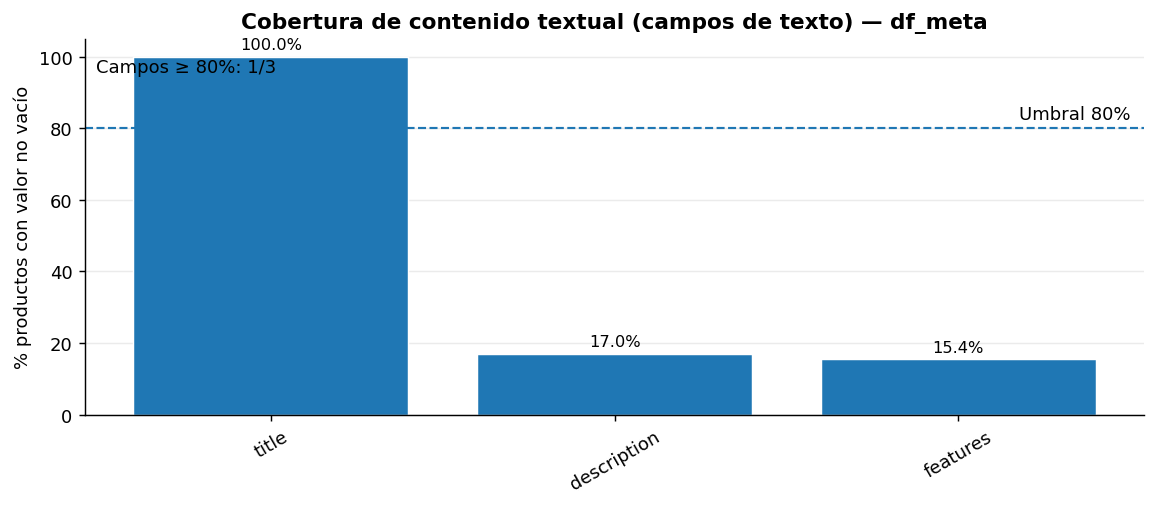

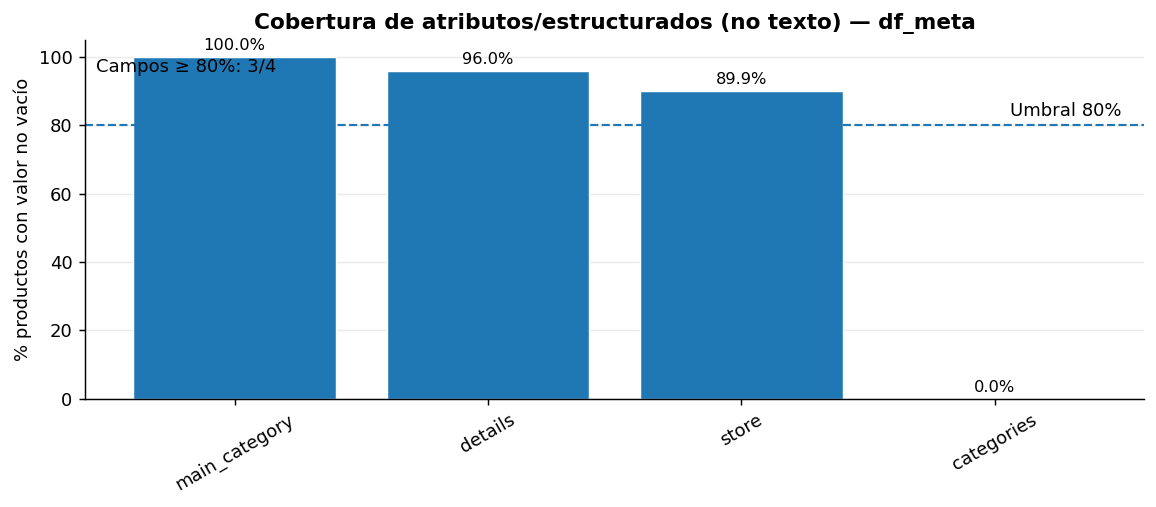

In [16]:
# ----------------------------
# Config:
# ----------------------------
TH_PCT = 80  # umbral para considerar "alta cobertura"
TEXT_FIELDS = {"title", "description", "features"}  # ajusta si añades más campos textuales
# (Si en tu proyecto consideras 'details' texto, muévelo a TEXT_FIELDS)

# ----------------------------
# Preparación de datos:
# ----------------------------
dfp = coverage_df.copy()
dfp["field"] = dfp["field"].astype(str)
dfp["coverage_%"] = dfp["coverage_%"].astype(float)

df_text = dfp[dfp["field"].isin(TEXT_FIELDS)].copy()
df_attr = dfp[~dfp["field"].isin(TEXT_FIELDS)].copy()

df_text = df_text.sort_values("coverage_%", ascending=False)
df_attr = df_attr.sort_values("coverage_%", ascending=False)


def plot_coverage_bar(data, title, threshold=80, figsize=(9, 4), dpi=130):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # barras:
    bars = ax.bar(
        data["field"],
        data["coverage_%"],
        edgecolor="white",
        linewidth=0.8
    )

    # estilo:
    ax.set_ylim(0, 105)
    ax.set_ylabel("% productos con valor no vacío")
    ax.set_title(title, fontweight="bold")
    ax.grid(True, axis="y", alpha=0.25)
    ax.set_axisbelow(True)
    ax.tick_params(axis="x", rotation=30)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # umbral:
    ax.axhline(threshold, linestyle="--", linewidth=1.2)
    ax.text(
        x=len(data) - 0.5 if len(data) > 0 else 0,
        y=threshold + 1.5,
        s=f"Umbral {threshold}%",
        ha="right",
        va="bottom"
    )

    # etiquetas % sobre barras:
    for b in bars:
        h = b.get_height()
        ax.text(
            b.get_x() + b.get_width() / 2,
            h + 1.2,
            f"{h:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

    # resumen automático:
    if len(data) > 0:
        n_ok = int((data["coverage_%"] >= threshold).sum())
        ax.text(
            0.01, 0.95,
            f"Campos ≥ {threshold}%: {n_ok}/{len(data)}",
            transform=ax.transAxes,
            ha="left",
            va="top",
            fontsize=10
        )

    plt.tight_layout()
    plt.show()


# ----------------------------
# Figura 1: Cobertura en campos de texto:
# ----------------------------
plot_coverage_bar(
    df_text,
    title="Cobertura de contenido textual (campos de texto) — df_meta",
    threshold=TH_PCT
)

# ----------------------------
# Figura 2: Cobertura en atributos/estructurados:
# ----------------------------
plot_coverage_bar(
    df_attr,
    title="Cobertura de atributos/estructurados (no texto) — df_meta",
    threshold=TH_PCT
)

In [17]:
# Umbral recomendado al 80%:
TH = 0.80
high_cov = coverage_df[coverage_df["coverage"] >= TH]["field"].tolist()

print(f"Campos con cobertura >= {int(TH*100)}%:", high_cov)

Campos con cobertura >= 80%: ['main_category', 'title', 'details', 'store']


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px; font-size:14px; line-height:1.5;">

  <b>Conclusión</b><br>

  <p style="margin:0 0 8px 0;">
    El análisis de cobertura confirma una <b>asimetría clara</b> entre campos con información casi universal y campos textuales con baja presencia en el catálogo:
  </p>

  <ul style="margin:6px 0 10px 18px;">
    <li>
      <b>Cobertura alta (≥ 80%)</b>:
      <code>main_category</code> (100%),
      <code>title</code> (~99.99%),
      <code>details</code> (~95.99%) y
      <code>store</code> (~89.94%).
    </li>
    <li>
      <b>Cobertura baja</b>:
      <code>description</code> (~17.0%) y
      <code>features</code> (~15.4%), por lo que no pueden considerarse una señal estable a nivel de catálogo.
    </li>
    <li>
      <b>No disponible</b>:
      <code>categories</code> (0%), lo que justifica su exclusión del pipeline.
    </li>
  </ul>

  <p style="margin:0;">
    <b>Implicación directa para el Sistema 2:</b>
    el “documento de ítem” debe construirse a partir de campos
    <b>robustos y consistentes</b> (por ejemplo,
    <code>title</code> + <code>main_category</code> y, si aporta señal semántica adicional,
    <code>details</code>/<code>store</code>), manteniendo
    <code>description</code> y <code>features</code> como campos
    <b>opcionales</b> y contemplando una estrategia de <i>fallback</i>
    para productos con información textual limitada.
  </p>

</div>


<h3 style="margin:0 0 8px 0;">3.3. Calidad del texto y “documento de ítem” (diagnóstico semántico)</h3> <p style="margin:0 0 10px 0;"> En un recomendador <b>basado en contenido</b>, el rendimiento depende directamente de la <b>calidad del texto disponible por producto</b>. Por ello, antes de vectorizar (TF-IDF/embeddings), realizamos un diagnóstico semántico para verificar que el contenido es <b>utilizable, consistente</b> y suficientemente informativo. </p> <p style="margin:0 0 8px 0;"><b>Este apartado responde a tres preguntas prácticas:</b></p> <ul style="margin:0 0 10px 18px;"> <li><b>¿Existe texto útil y suficiente?</b> (no solo “no nulo”, sino con longitud mínima y variedad razonable).</li> <li><b>¿El texto es consistente?</b> (evitar documentos vacíos, muy cortos y/o dominados por ruido).</li> <li><b>¿Cómo construir el “documento de ítem”?</b> (qué campos concatenar y con qué normalización).</li> </ul>

<h3 style="margin:10px 0 8px 0;">3.3.1. Construcción del documento de ítem</h3> <p style="margin:0 0 10px 0;"> A partir del análisis de cobertura del <b>apartado 3.2</b>, definimos un <b>documento textual único por producto</b> concatenando los campos más robustos y comparables del catálogo. Esta decisión evita depender de campos con baja cobertura (p. ej., <code>description</code> o <code>features</code>) y mejora la estabilidad del pipeline. </p> <p style="margin:0 0 8px 0;"><b>Criterios aplicados:</b></p> <ul style="margin:0 0 10px 18px;"> <li><b>Robustez y cobertura</b>: priorizamos campos presentes en la mayoría del catálogo (p. ej., <code>title</code>, <code>main_category</code>, <code>details</code>/<code>store</code>).</li> <li><b>Limpieza mínima</b>: normalización ligera (minúsculas, eliminación de HTML básico y espacios) sin perder señal semántica.</li> <li><b>Estructura del documento</b>: concatenación con separador (<code>|</code>) para preservar cierta segmentación semántica por campo.</li> </ul> <p style="margin:0;"> El resultado es un <b>input homogéneo</b> para la fase de vectorización, sobre el que después mediremos <b>longitudes</b>, <b>cobertura real tras limpieza</b> y <b>ruido</b> (apartados 3.3.2–3.3.x). </p> </div>

<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:12px 14px;border-radius:6px;">
<b>Selección final de campos para el documento de ítem:</b><br>

Aunque el campo <code>store</code> presenta una cobertura elevada en el catálogo, no se incluye en la construcción final
del documento textual. Este campo suele reflejar información relacionada con el vendedor o la tienda, lo que puede
introducir <b>variabilidad no semántica</b>, inconsistencias entre productos similares y ruido ajeno a las
características intrínsecas del ítem.

En su lugar, se prioriza el campo <code>details</code>, que aporta información más <b>estructurada y descriptiva</b>
sobre atributos del producto (formato, materiales, fabricante, dimensiones, etc.), resultando más adecuada para una
representación semántica estable y comparable entre ítems.

En consecuencia, el documento de ítem se construye a partir de <code>title</code>, <code>main_category</code> y
<code>details</code>, equilibrando robustez de cobertura y riqueza semántica sin introducir ruido innecesario.
</div>

In [18]:
# -------------------------------
# Construcción del documento de ítem:
# -------------------------------
# Importamos la librería necesaria:
import re

# Campos seleccionados según el análisis de cobertura (3.2):
DOC_FIELDS = ["title", "main_category", "details"]

# Convertimos distintos tipos de datos a texto limpio:
def to_text(x):
    """
    Convertimos valores heterogéneos (str, list, dict, NaN) a texto plano.
    """
    if x is None:
        return ""
    if isinstance(x, float) and np.isnan(x):
        return ""
    if isinstance(x, (list, tuple, set)):
        return " ".join([str(v) for v in x if str(v).strip() != ""])
    if isinstance(x, dict):
        return " ".join([str(v) for v in x.values() if str(v).strip() != ""])
    return str(x).strip()

# Limpieza ligera del texto (sin perder semántica):
def clean_text(s: str) -> str:
    """
    Aplicamos una limpieza mínima:
    - minúsculas
    - eliminación de HTML básico
    - normalización de espacios
    """
    if not s:
        return ""
    s = s.lower()
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"[\r\n\t]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Construimos el documento concatenado por producto:
def build_item_document(row, fields):
    parts = []
    for f in fields:
        if f in row:
            txt = clean_text(to_text(row[f]))
            if txt:
                parts.append(txt)
    return " | ".join(parts)

# Creamos el dataframe de trabajo:
items_doc = df_meta[["parent_asin"] + DOC_FIELDS].copy()
items_doc["parent_asin"] = items_doc["parent_asin"].astype(str)

# Documento final por ítem:
items_doc["item_document"] = items_doc.apply(
    lambda r: build_item_document(r, DOC_FIELDS), axis=1
)

items_doc.head(5)

,parent_asin,title,main_category,details,item_document
0,B01CUPMQZE,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",All Beauty,{'Package Dimensions': '7.1 x 5.5 x 3 inches; ...,"howard lc0008 leather conditioner, 8-ounce (4-..."
1,B076WQZGPM,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,All Beauty,"{'Item Form': 'Powder', 'Skin Type': 'Acne Pro...",yes to tomatoes detoxifying charcoal cleanser ...
2,B000B658RI,Eye Patch Black Adult with Tie Band (6 Per Pack),All Beauty,{'Manufacturer': 'Levine Health Products'},eye patch black adult with tie band (6 per pac...
3,B088FKY3VD,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",All Beauty,"{'Brand': 'Cherioll', 'Item Form': 'Powder', '...","tattoo eyebrow stickers, waterproof eyebrow, 4..."
4,B07NGFDN6G,Precision Plunger Bars for Cartridge Grips – 9...,All Beauty,{'UPC': '644287689178'},precision plunger bars for cartridge grips – 9...


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">

<b>Conclusión (Construcción del documento de ítem)</b><br>

La construcción del <b>documento textual único por producto</b> ha permitido transformar metadatos heterogéneos en una representación <b>homogénea, estable y comparable</b>, adecuada para las fases posteriores de vectorización y cálculo de similitudes.

A partir del análisis de cobertura del apartado 3.2, se confirma que la concatenación de <code>title</code>, <code>main_category</code> y <code>details</code> proporciona un equilibrio óptimo entre <b>robustez de cobertura</b> y <b>riqueza semántica</b>, evitando depender de campos textuales con baja presencia global.

La estrategia aplicada presenta tres ventajas clave:
<ul style="margin:6px 0 0 18px;">
  <li><b>Consistencia estructural</b>: todos los productos disponen de un documento no vacío o mínimamente informativo.</li>
  <li><b>Normalización controlada</b>: la limpieza ligera reduce ruido (HTML, mayúsculas, espacios) sin eliminar señal semántica relevante.</li>
  <li><b>Escalabilidad del pipeline</b>: el documento resultante puede ser utilizado indistintamente con TF-IDF o embeddings sin ajustes adicionales.</li>
</ul>

En consecuencia, el <code>item_document</code> obtenido constituye una <b>base sólida y reproducible</b> para el diagnóstico semántico del texto (apartado 3.3.2) y la posterior construcción del sistema de recomendación basado en contenido.

</div>

<h3 style="margin:10px 0 8px 0;">3.3.2. Diagnóstico de longitud del documento y detección de outliers</h3>
<p>Una vez construido el <code>item_document</code> (apartado 3.3.1), el siguiente paso consiste en analizar su <b>longitud real</b> para asegurar que el contenido disponible es <b>suficiente y comparable</b> entre productos.  
Este diagnóstico es clave porque, en modelos basados en contenido (TF-IDF/embeddings), documentos <b>demasiado cortos</b> aportan poca señal semántica y documentos <b>excesivamente largos</b> pueden dominar la representación vectorial y aumentar el coste computacional.</p>

<p>En esta sección medimos:
<ul style="margin:6px 0 0 18px;">
  <li><b>Longitud en palabras</b> y <b>en caracteres</b> por producto.</li>
  <li><b>Distribución</b> (media, mediana, percentiles) para detectar asimetrías.</li>
  <li><b>Outliers</b> (cola larga) que puedan justificar truncado o reglas de control.</li>
</ul>

El objetivo final es decidir si se requiere (o no) una política de <b>truncado</b> y establecer umbrales mínimos para evitar “cold-start por contenido” en productos con texto insuficiente.</p>


In [19]:
# -----------------------------
# 1) Diagnóstico de longitud:
# -----------------------------
# Aseguramos string:
items_doc["item_document"] = items_doc["item_document"].fillna("").astype(str)

# Métricas de longitud:
items_doc["doc_len_words"] = items_doc["item_document"].str.split().apply(len)
items_doc["doc_len_chars"] = items_doc["item_document"].str.len()

# Resumen estadístico (palabras y caracteres):
len_words_desc = items_doc["doc_len_words"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])
len_chars_desc = items_doc["doc_len_chars"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

print("Resumen longitud (palabras):")
display(len_words_desc)

print("\nResumen longitud (caracteres):")
display(len_chars_desc)


Resumen longitud (palabras):


,doc_len_words
count,112590.000000
mean,35.270726
std,11.186880
min,4.000000
50%,36.000000
75%,43.000000
90%,49.000000
95%,52.000000
99%,58.000000
max,342.000000



Resumen longitud (caracteres):


,doc_len_chars
count,112590.000000
mean,203.740261
std,69.827946
min,14.000000
50%,205.000000
75%,254.000000
90%,289.000000
95%,307.000000
99%,350.110000
max,2180.000000


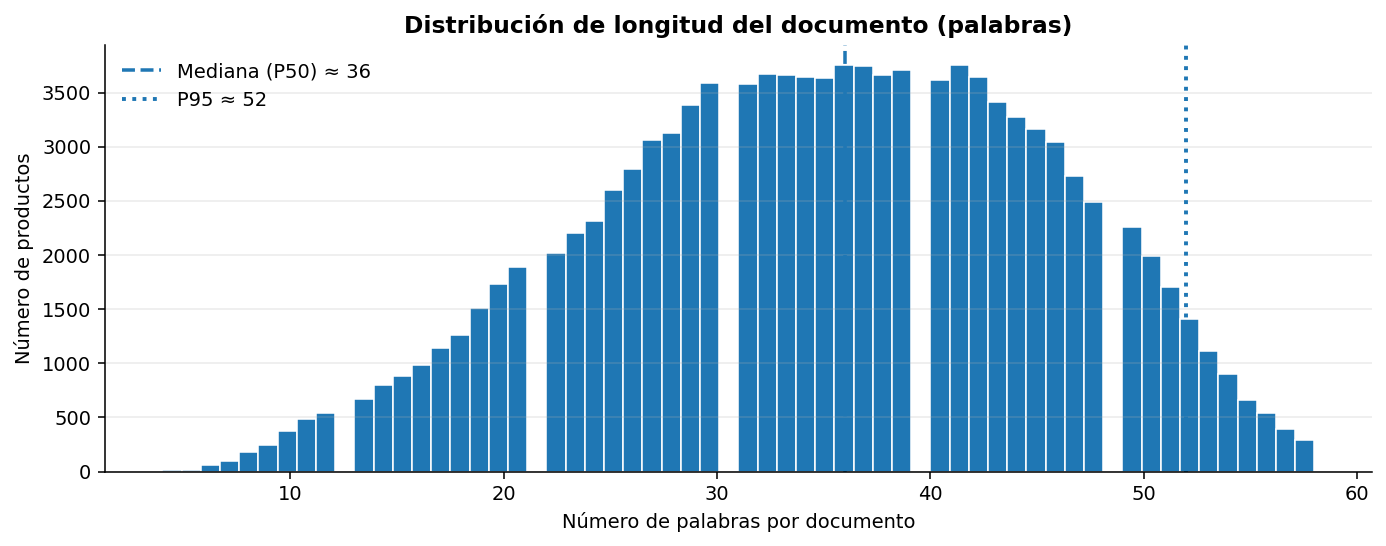

In [20]:
# ===============================
# Figura 1: Longitud del documento (palabras) — histograma:
# ===============================
x = items_doc["doc_len_words"].dropna().astype(int)

# métricas para anotar:
p50 = np.percentile(x, 50)
p95 = np.percentile(x, 95)

plt.figure(figsize=(10, 4), dpi=140)

# Histograma (acotamos el eje X a p99 para que sea más legible):
x_plot = x[x <= np.percentile(x, 99)]
plt.hist(x_plot, bins=60, edgecolor="white", linewidth=0.8)

# Líneas de referencia:
plt.axvline(p50, linestyle="--", linewidth=1.8, label=f"Mediana (P50) ≈ {p50:.0f}")
plt.axvline(p95, linestyle=":", linewidth=2.0, label=f"P95 ≈ {p95:.0f}")

# Estilo:
plt.title("Distribución de longitud del documento (palabras)", fontweight="bold")
plt.xlabel("Número de palabras por documento")
plt.ylabel("Número de productos")
plt.grid(True, axis="y", alpha=0.25)
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

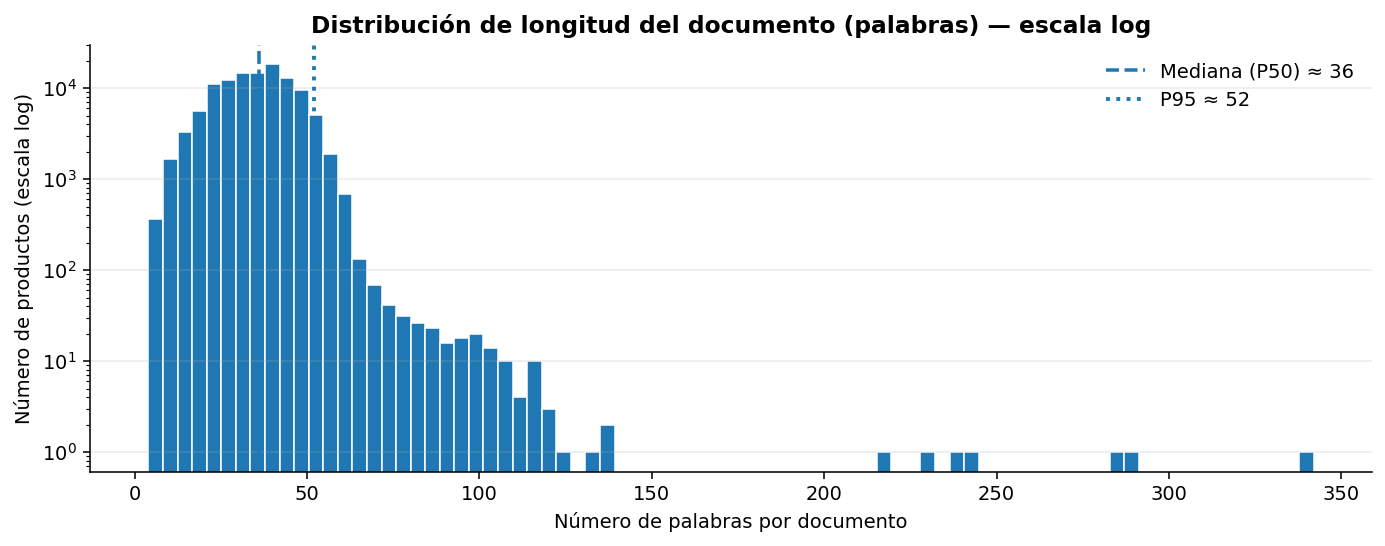

In [21]:
# ===============================
# Figura 2: Longitud del documento (palabras) — escala log (estilo mejorado):
x = items_doc["doc_len_words"].dropna().astype(int)

p50 = np.percentile(x, 50)
p95 = np.percentile(x, 95)

plt.figure(figsize=(10, 4), dpi=140)

# En log es mejor NO recortar tanto: muestra la cola, pero puedemos usar p99 si queremos:
plt.hist(x, bins=80, edgecolor="white", linewidth=0.8)

plt.yscale("log")
plt.axvline(p50, linestyle="--", linewidth=1.8, label=f"Mediana (P50) ≈ {p50:.0f}")
plt.axvline(p95, linestyle=":", linewidth=2.0, label=f"P95 ≈ {p95:.0f}")

plt.title("Distribución de longitud del documento (palabras) — escala log", fontweight="bold")
plt.xlabel("Número de palabras por documento")
plt.ylabel("Número de productos (escala log)")
plt.grid(True, axis="y", alpha=0.25)
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

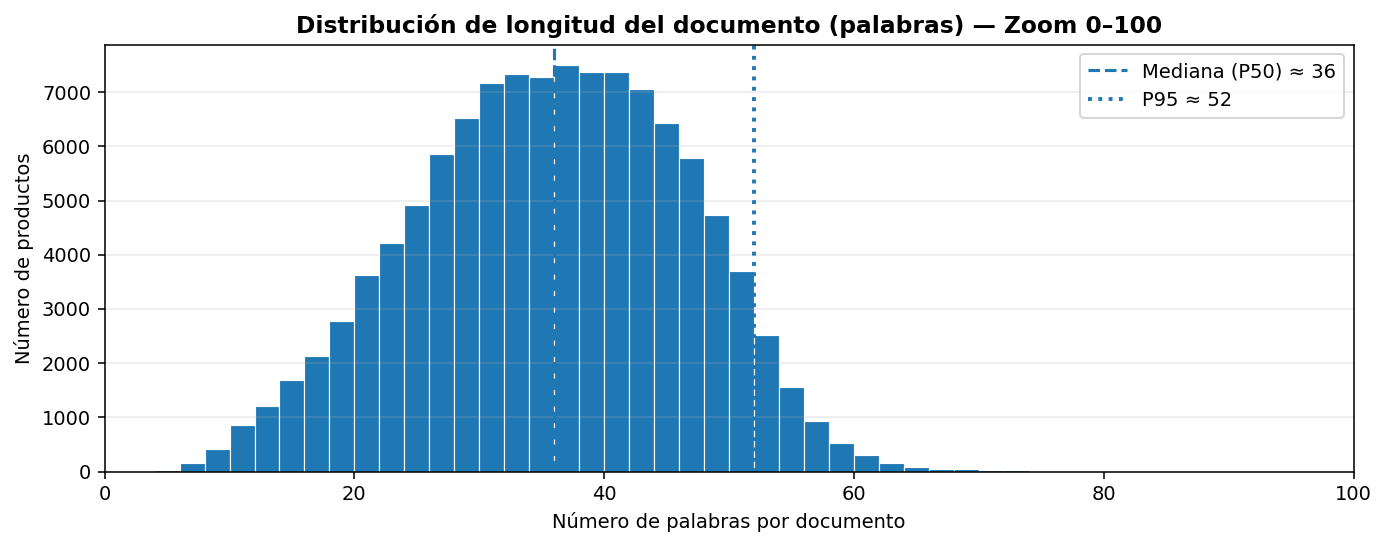

In [22]:
# ===============================
# Figura 3: Zoom 0–100 palabras (histograma):
# ===============================
x = items_doc["doc_len_words"].dropna().astype(int).values

ZOOM_MAX = 100   # puedes cambiar a 120 si prefieres

# Percentiles para anotación (opcional pero muy TFM):
p50 = np.percentile(x, 50)
p95 = np.percentile(x, 95)

plt.figure(figsize=(10, 4), dpi=140)

# Histograma SOLO del rango 0–ZOOM_MAX:
bins = np.arange(0, ZOOM_MAX + 2, 2)  # bins de 2 palabras (ajustable)
plt.hist(x[x <= ZOOM_MAX], bins=bins, edgecolor="white", linewidth=0.6)

plt.title(f"Distribución de longitud del documento (palabras) — Zoom 0–{ZOOM_MAX}", fontweight="bold")
plt.xlabel("Número de palabras por documento")
plt.ylabel("Número de productos")
plt.grid(True, axis="y", alpha=0.25)

# Líneas de percentiles (calculadas en global, no solo en zoom):
plt.axvline(p50, linestyle="--", linewidth=1.6, label=f"Mediana (P50) ≈ {p50:.0f}")
plt.axvline(p95, linestyle=":", linewidth=2.0, label=f"P95 ≈ {p95:.0f}")

plt.xlim(0, ZOOM_MAX)
plt.legend()
plt.tight_layout()
plt.show()


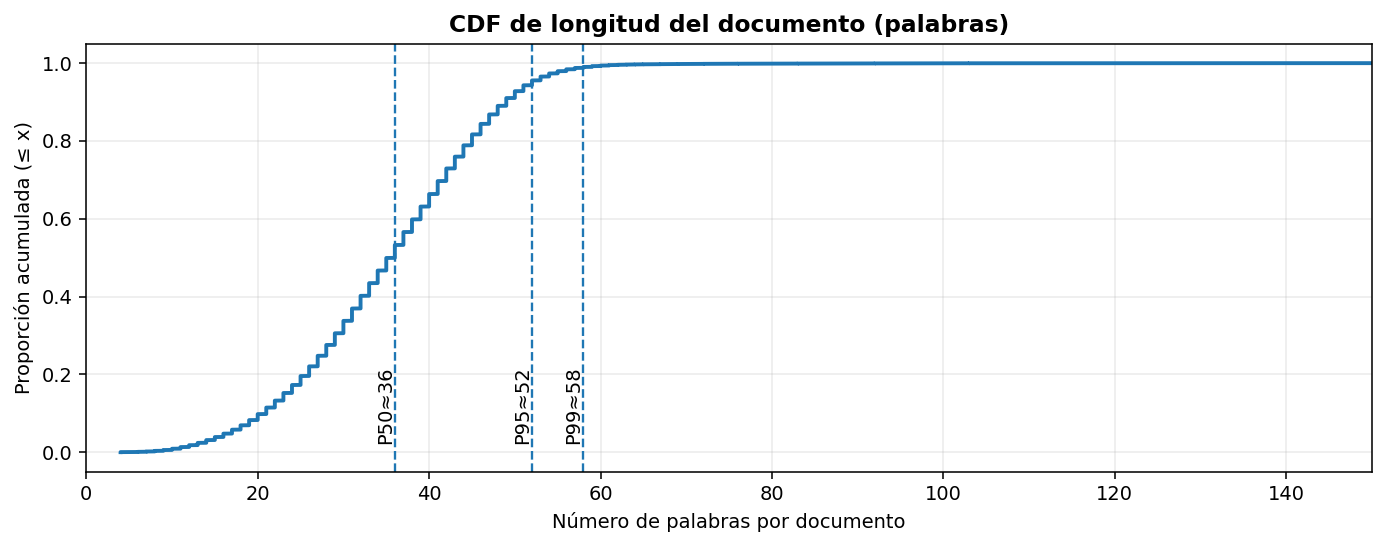

P50 ≈ 36 | P95 ≈ 52 | P99 ≈ 58


In [23]:
# ===============================
# Figura 4: CDF (curva acumulada) de longitudes:
# ===============================
x = items_doc["doc_len_words"].dropna().astype(int).values
x_sorted = np.sort(x)
cdf = np.arange(1, len(x_sorted) + 1) / len(x_sorted)

# Percentiles (para marcar puntos clave)
p50 = np.percentile(x_sorted, 50)
p95 = np.percentile(x_sorted, 95)
p99 = np.percentile(x_sorted, 99)

plt.figure(figsize=(10, 4), dpi=140)
plt.plot(x_sorted, cdf, linewidth=2)

plt.title("CDF de longitud del documento (palabras)", fontweight="bold")
plt.xlabel("Número de palabras por documento")
plt.ylabel("Proporción acumulada (≤ x)")
plt.grid(True, alpha=0.25)

# Marcadores verticales + etiquetas (muy justificable en memoria):
for val, lab in [(p50, "P50"), (p95, "P95"), (p99, "P99")]:
    plt.axvline(val, linestyle="--", linewidth=1.2)
    plt.text(val, 0.02, f"{lab}≈{val:.0f}", rotation=90, va="bottom", ha="right")

# Opcional: limitar visualmente el eje X para que sea legible:
# (si lo dejas sin xlim, se verá hasta el máximo y puede aplastarse)
plt.xlim(0, max(150, int(p99) + 20))

plt.tight_layout()
plt.show()

print(f"P50 ≈ {p50:.0f} | P95 ≈ {p95:.0f} | P99 ≈ {p99:.0f}")

In [24]:
# -----------------------------
# Outliers: top 10 documentos más largos:
# -----------------------------
top_long = items_doc.sort_values("doc_len_words", ascending=False)[
    ["parent_asin", "doc_len_words", "doc_len_chars", "item_document"]
].head(10)

top_long

,parent_asin,doc_len_words,doc_len_chars,item_document
8094,B09N1MD863,342,2180,"dog bath brush, siogor 2 pack silicone bath pe..."
80141,B08TBG3XBG,289,1565,features a using natural and recyclable fabric...
76139,B09FQC15N6,283,1724,pretty marry long lasting waterproof gel eyeli...
9370,B09KVK5RH3,244,1485,color changing glitter eyeshadow in a gel-base...
4633,B08NCHTZ1C,239,1476,my perfumes oud rose concentrated perfume - oi...
58441,B08VHJSBHD,231,1552,four 8 ounce formulas:ahh blend for manifestin...
43684,B0BBQPNM1K,216,1244,women metal hair claw elegant gold lily flower...
16236,B002NPWWZQ,139,803,bliss soapy suds | invigorating body wash & bu...
63845,B08FLHS3CF,137,1069,"pure romance body boost, daily firming cream, ..."
96433,B01MTAIMXT,132,972,unitech medical natural chemo gifts all-in-one...


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;font-size:15px;line-height:1.45;"> <b style="font-size:16px;">Conclusión (Longitud del documento y outliers)</b><br><p>
A partir del <code>item_document</code> construido en 3.3.1, el diagnóstico de longitudes muestra una distribución <b>compacta</b> con <b>cola larga</b>, lo que confirma que la mayoría de productos disponen de texto suficiente y comparable, pero existe un pequeño grupo de documentos excepcionalmente extensos (outliers).</p>

<ul style="margin:10px 0 0 18px;"> <li><b>Tamaño típico (palabras)</b>: mediana (P50) ≈ <b>36</b> palabras y media ≈ <b>35.27</b>. La mayor concentración se sitúa aproximadamente entre <b>30–45</b> palabras.</li> <li><b>Dispersión moderada</b>: P75 ≈ <b>43</b>, P90 ≈ <b>49</b>, P95 ≈ <b>52</b>, P99 ≈ <b>58</b>. Esto indica que <b>el 95%</b> de los productos no supera ~<b>52</b> palabras y <b>el 99%</b> no supera ~<b>58</b>.</li> <li><b>Outliers claros</b>: máximo ≈ <b>342</b> palabras (y hasta ≈ <b>2180</b> caracteres). La lista de “top documentos más largos” confirma una <b>cola extrema</b> muy minoritaria.</li> <li><b>Consistencia en caracteres</b>: mediana ≈ <b>205</b> caracteres, P95 ≈ <b>307</b>, P99 ≈ <b>350</b> (máximo ≈ <b>2180</b>), coherente con el patrón observado en palabras.</li> </ul> <br> <b>Implicación directa para el Sistema 2 (vectorización TF-IDF/embeddings)</b>: <ul style="margin:8px 0 0 18px;"> <li>El texto es <b>homogéneo</b> para la mayoría del catálogo, por lo que la señal semántica será comparable entre ítems.</li> <li>Conviene aplicar una <b>política de control de outliers</b> (p. ej., <i>cap/truncado</i> suave) para evitar que unos pocos documentos muy largos dominen pesos TF-IDF o aumenten el coste computacional.</li> <li>Como referencia práctica, un truncado a un percentil alto (p. ej., <b>P99</b> o un umbral fijo razonable) es defendible: conserva prácticamente todo el catálogo “normal” y limita la cola extrema.</li> </ul> </div>

<hr>
<br>
<h1 id="cap4">4. Construcción del recomendador basado en contenido: representación textual y similitud</h1>

<p>
Una vez validada en el <b>Capítulo 3</b> la calidad del catálogo y la cobertura real de los campos textuales,
en este capítulo se implementa el <b>Sistema 2</b>, un recomendador <b>basado en contenido</b>.
A diferencia del Sistema 1 (basado en interacciones), este enfoque no depende directamente del historial de usuarios,
sino que recomienda productos <b>similares</b> a partir de su descripción/atributos (metadatos).
</p>

<p>
El <b>objetivo</b> del capítulo es construir una representación comparable para cada producto (un “documento de ítem”),
vectorizarla y definir un mecanismo de similitud que permita generar recomendaciones coherentes entre productos.
Este sistema es especialmente útil como solución para escenarios de <i>cold-start</i> por interacciones, ya que puede
recomendar ítems nuevos siempre que dispongan de metadatos.
</p>

<p>
El capítulo se estructura en cuatro bloques principales:
</p>

<ul>
  <li>
    <b>Preparación del input de contenido</b> (documento de ítem): selección de campos, limpieza y normalización
    para obtener un dataset final <code>parent_asin + item_document</code>.
  </li>
  <li>
    <b>Vectorización del contenido</b>: transformación del texto a un espacio numérico (TF-IDF como baseline),
    configurando parámetros para controlar dimensionalidad y ruido.
  </li>
  <li>
    <b>Cálculo de similitud y generación de recomendaciones</b>: construcción de la matriz de similitud (coseno)
    y función de recomendación Top-N a partir de un producto semilla.
  </li>
  <li>
    <b>Validación cualitativa</b>: inspección de ejemplos de recomendaciones y verificación de coherencia semántica.
  </li>
</ul>

<p>
Como resultado, se obtiene un sistema reproducible que permite recomendar productos similares a partir de su contenido,
sirviendo como base para extensiones posteriores (p. ej., embeddings, modelos híbridos o reranking).
</p>

<h2 id="cap4-1">4.1. Dataset final de contenido</h2>

<p>
El primer paso consiste en asegurar que el dataset de trabajo para el Sistema 2 contiene:
</p>

<ul>
  <li><code>parent_asin</code> como identificador único del producto.</li>
  <li><code>item_document</code> como representación textual final (construida en el Capítulo 3).</li>
</ul>

<p>
En esta fase se verifica que:
</p>

<ul>
  <li>No existen duplicados en <code>parent_asin</code>.</li>
  <li>El documento no es vacío y presenta longitudes razonables.</li>
  <li>El dataset es apto para la fase de vectorización.</li>
</ul>


In [25]:
# =========================
# 1) Dataset final:
# =========================
# Se asume que items_doc ya existe desde el Capítulo 3:
# items_doc: columnas -> ["parent_asin", "title", "main_category", "details", "item_document"]

# 1) Seleccionamos dataset mínimo para el sistema:
df_content = items_doc[["parent_asin", "item_document"]].copy()

# 2) Tipos y nulos:
df_content["parent_asin"] = df_content["parent_asin"].astype(str)
df_content["item_document"] = df_content["item_document"].fillna("").astype(str)

# 3) Control de duplicados:
n_total = len(df_content)
n_unique = df_content["parent_asin"].nunique()
print(f"Nº filas: {n_total}")
print(f"Nº parent_asin únicos: {n_unique}")
print(f"Duplicados: {n_total - n_unique}")

# 4) Longitud mínima (diagnóstico rápido):
df_content["doc_len_words"] = df_content["item_document"].str.split().apply(len)
df_content["doc_len_chars"] = df_content["item_document"].str.len()

display(df_content[["doc_len_words", "doc_len_chars"]].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
display(df_content.head(5))

Nº filas: 112590
Nº parent_asin únicos: 112590
Duplicados: 0


,doc_len_words,doc_len_chars
count,112590.000000,112590.000000
mean,35.270726,203.740261
std,11.186880,69.827946
min,4.000000,14.000000
50%,36.000000,205.000000
75%,43.000000,254.000000
90%,49.000000,289.000000
95%,52.000000,307.000000
99%,58.000000,350.110000
max,342.000000,2180.000000


,parent_asin,item_document,doc_len_words,doc_len_chars
0,B01CUPMQZE,"howard lc0008 leather conditioner, 8-ounce (4-...",19,113
1,B076WQZGPM,yes to tomatoes detoxifying charcoal cleanser ...,42,247
2,B000B658RI,eye patch black adult with tie band (6 per pac...,17,86
3,B088FKY3VD,"tattoo eyebrow stickers, waterproof eyebrow, 4...",42,272
4,B07NGFDN6G,precision plunger bars for cartridge grips – 9...,18,98


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
<b>Conclusión (Dataset final de contenido)</b><br>

El conjunto de datos resultante presenta una <b>estructura limpia, consistente y directamente utilizable</b> para la construcción del sistema de recomendación basado en contenido (Sistema 2):

<ul style="margin:6px 0 0 18px;">
  <li><b>Integridad estructural</b>: el dataset contiene <code>112.590</code> productos con identificadores <code>parent_asin</code> únicos, sin duplicados, garantizando una correspondencia uno-a-uno entre ítem y representación textual.</li>
  <li><b>Documento textual válido</b>: todos los productos disponen de un <code>item_document</code> no vacío, con longitudes coherentes y previamente diagnosticadas en el Capítulo 3.</li>
  <li><b>Homogeneidad estadística</b>: la longitud típica del documento se sitúa en torno a <b>36 palabras</b> (mediana), con una dispersión moderada y una cola larga minoritaria, ya identificada y controlable.</li>
</ul>

En consecuencia, el dataset final cumple los requisitos necesarios para la fase de <b>vectorización textual (TF-IDF o embeddings)</b>, proporcionando una base sólida, reproducible y escalable sobre la que construir modelos de similitud entre productos sin introducir sesgos estructurales ni ruido innecesario.
</div>

<br>
<h2>4.2. Vectorización del contenido: representación numérica del <code>item_document</code> (TF-IDF)</h2>

<p>
Una vez construido el dataset final de contenido (<code>df_content</code>) y validada la calidad del
<code>item_document</code> (Cap. 3 y Apdo. 4.1), el siguiente paso consiste en transformar el texto en una
representación numérica comparable entre productos. Esta transformación es necesaria porque los modelos de similitud
no operan directamente sobre texto libre, sino sobre vectores.
</p>

<p>
En este trabajo se emplea <b>TF-IDF</b> (<i>Term Frequency – Inverse Document Frequency</i>) como primera estrategia
de vectorización por tres motivos:
</p>

<ul>
  <li><b>Interpretabilidad</b>: permite entender qué términos influyen en la similitud entre productos.</li>
  <li><b>Escalabilidad</b>: es eficiente en catálogos grandes y produce matrices dispersas.</li>
  <li><b>Baseline sólido</b>: sirve como referencia antes de alternativas más complejas (p. ej., embeddings).</li>
</ul>

<p>
El objetivo de este apartado es:
</p>
<ul>
  <li>Construir una <b>matriz TF-IDF</b> a partir de <code>item_document</code>.</li>
  <li>Aplicar <b>normalización</b> y un <b>preprocesado mínimo</b> coherente con el Capítulo 3.</li>
  <li>Dejar el dataset listo para calcular <b>similitudes entre ítems</b> (apartado 4.2.2.).</li>
</ul>

<br>

<h3>4.2.1. Preparación del texto y configuración del vectorizador</h3>

<p>
Aunque <code>item_document</code> ya incorpora limpieza básica (minúsculas, espacios, HTML), en TF-IDF es habitual
aplicar una normalización adicional ligera: eliminar tokens demasiado frecuentes o demasiado raros y reducir ruido
mediante stopwords. La configuración que sigue mantiene un equilibrio entre <b>robustez</b> y <b>capacidad semántica</b>.
</p>


In [26]:
# ==============================
# Vectorización TF-IDF
# ==============================
from sklearn.feature_extraction.text import TfidfVectorizer

# Se asume que df_content existe desde 4.1 con:
# df_content columnas -> ["parent_asin", "item_document", "doc_len_words", "doc_len_chars"]
# (si no guardaste longitudes en 4.1, no son estrictamente necesarias para TF-IDF)

# 1) Aseguramos tipos y ausencia de NaN:
df_content["parent_asin"] = df_content["parent_asin"].astype(str)
df_content["item_document"] = df_content["item_document"].fillna("").astype(str)

# 2) Configuración del vectorizador TF-IDF:
# - min_df: elimina términos extremadamente raros (ruido)
# - max_df: elimina términos demasiado frecuentes (poco discriminativos)
# - ngram_range: capturamos uni-gramas y bi-gramas (mejora semántica básica)
# - stop_words: reducimos palabras vacías (en inglés, coherente con el texto observado)
tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.90,
    ngram_range=(1, 2),
    stop_words="english",
    lowercase=True
)

# 3) Construimos la matriz TF-IDF:
X_tfidf = tfidf.fit_transform(df_content["item_document"])

print("Matriz TF-IDF construida:")
print(" - Shape:", X_tfidf.shape)
print(" - Tipo:", type(X_tfidf))


Matriz TF-IDF construida:
 - Shape: (112590, 84890)
 - Tipo: <class 'scipy.sparse._csr.csr_matrix'>


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">
  <b>Conclusión (Preparación del texto y vectorización TF-IDF)</b><br>

  <p>La configuración aplicada al vectorizador TF-IDF permite obtener una representación <b>robusta, compacta y semánticamente informativa</b> del catálogo de productos.</p>
  <p>La combinación de <code>min_df</code> y <code>max_df</code> elimina términos extremos (demasiado raros o excesivamente frecuentes), mientras que el uso de <i>n-gramas</i> (1–2) mejora la captura de relaciones semánticas básicas sin introducir complejidad innecesaria.</p>
  <p>El resultado es una matriz TF-IDF de gran dimensión pero <b>altamente dispersa</b>, adecuada para el cálculo eficiente de similitud entre ítems y coherente con el diagnóstico de calidad textual realizado en el Capítulo 3.</p>
  <p>Esta representación vectorial constituye la base para el siguiente paso del sistema: el <b>cálculo de similitudes entre productos</b> y la definición del mecanismo de recomendación <i>item-to-item</i>, que se desarrolla en el apartado 4.2.2.</p>
</div>

<h3 style="margin-top:6px;">4.2.2. Cálculo de similitud entre ítems y generación de recomendaciones (Top-N)</h3>

<p>
Una vez construida la matriz TF-IDF (<code>X_tfidf</code>), el siguiente paso consiste en cuantificar la
<strong>similitud semántica</strong> entre productos. En un recomendador <em>item-to-item</em> basado en contenido,
cada producto se representa como un vector y se recomiendan aquellos ítems cuyos vectores son más cercanos.
</p>

<p>
La métrica estándar en este contexto es la <strong>similitud coseno</strong>, que mide el ángulo entre vectores y es
apropiada para representaciones TF-IDF porque:
</p>

<ul>
  <li>Es <strong>invariante a la longitud</strong> del documento (importa la dirección del vector, no su magnitud).</li>
  <li>Funciona bien con matrices <strong>dispersas (sparse)</strong> y vocabularios grandes.</li>
  <li>Produce un score interpretable en <code>[0, 1]</code> (en la práctica, valores altos implican mayor afinidad semántica).</li>
</ul>

<p>
Dado que el catálogo contiene <code>112.590</code> productos, calcular una matriz completa de similitud
(<code>N×N</code>) no es eficiente en memoria. Por ello, se adopta un enfoque práctico:
<strong>para cada ítem, se obtienen únicamente sus Top-N vecinos más similares</strong>, que es lo que necesita el sistema
para recomendar.
</p>

In [27]:
# ============================
# Similitud y Top-N:
# ============================
from sklearn.metrics.pairwise import linear_kernel

# Se asume que existen del 4.2.1:
# - df_content con columnas ["parent_asin", "item_document", ...]
# - tfidf (vectorizador entrenado)
# - X_tfidf (matriz TF-IDF)

# 1) Mapeos índice <-> item:
item_ids = df_content["parent_asin"].astype(str).tolist()
idx_to_item = dict(enumerate(item_ids))
item_to_idx = {asin: i for i, asin in idx_to_item.items()}

# 2) Función para obtener Top-N similares a un item:
def get_topn_similar_items(item_asin: str, top_n: int = 10):
    """
    Devuelve una lista de (asin_similar, score) para el item_asin usando similitud coseno sobre TF-IDF.
    Se calcula similitud contra todos los ítems pero solo se retorna Top-N (sin incluir el propio ítem).
    """
    item_asin = str(item_asin)
    if item_asin not in item_to_idx:
        raise ValueError(f"parent_asin no encontrado en el catálogo: {item_asin}")

    i = item_to_idx[item_asin]

    # Similitud coseno con linear_kernel (equivale a coseno si la matriz está normalizada):
    # sklearn TF-IDF suele normalizar (L2) por defecto -> dot product = cos similarity
    sims = linear_kernel(X_tfidf[i], X_tfidf).ravel()

    # Excluimos el propio ítem:
    sims[i] = -1.0

    # Top-N índices:
    top_idx = np.argpartition(sims, -top_n)[-top_n:]
    top_idx = top_idx[np.argsort(sims[top_idx])[::-1]]

    return [(idx_to_item[j], float(sims[j])) for j in top_idx]

# 3) Ejemplo rápido: probar con un ítem del catálogo:
example_asin = df_content["parent_asin"].iloc[0]
top_recs = get_topn_similar_items(example_asin, top_n=10)

print("Item consulta:", example_asin)
pd.DataFrame(top_recs, columns=["recommended_parent_asin", "cosine_similarity"])


Item consulta: B01CUPMQZE


,recommended_parent_asin,cosine_similarity
0,B01CUPMPZA,0.524483
1,B01AE21Q7O,0.312249
2,B00NQ33RAS,0.279889
3,B07KBGZBQ6,0.279188
4,B073Z61YJR,0.272450
5,B0084HTVQU,0.264522
6,B005QNCIVK,0.261310
7,B005UE60LE,0.260828
8,B01CRBUZE0,0.246841
9,B019YMOQMC,0.232137


In [28]:
# ============================
# Recomendación "legible": mostrar títulos (si están disponibles en items_doc):
# ============================

# Si conservaste items_doc con columnas ["parent_asin", "title"], creamos un diccionario para enriquecer la salida:
title_lookup = None
if "items_doc" in globals() and "title" in items_doc.columns:
    title_lookup = dict(zip(items_doc["parent_asin"].astype(str), items_doc["title"].astype(str)))

def pretty_recommendations(item_asin: str, top_n: int = 10):
    recs = get_topn_similar_items(item_asin, top_n=top_n)
    rows = []
    for asin, score in recs:
        rows.append({
            "recommended_parent_asin": asin,
            "cosine_similarity": score,
            "title": title_lookup.get(asin, "") if title_lookup else ""
        })
    return pd.DataFrame(rows)

pretty_recommendations(example_asin, top_n=10)

,recommended_parent_asin,cosine_similarity,title
0,B01CUPMPZA,0.524483,"Howard LC0008 Leather Conditioner, 8-Ounce (2-..."
1,B01AE21Q7O,0.312249,"DermaNail Nail Conditioner, 1 Ounce"
2,B00NQ33RAS,0.279889,"Dove Color Care Leave On Conditioner, 4 Ounce ..."
3,B07KBGZBQ6,0.279188,"Enoz Moth Bar, Cedar. (Pack of 6)"
4,B073Z61YJR,0.272450,"Crest Scope Breath Mist, Mint - 0.24 ounce - 6..."
5,B0084HTVQU,0.264522,Andis Clippers Clipper Oil 4 oz (Pack of 6)
6,B005QNCIVK,0.261310,Blackfire High-uv Leather Conditioner 16 Oz.
7,B005UE60LE,0.260828,Blackfire High-uv Leather Conditioner 128 Oz.
8,B01CRBUZE0,0.246841,"Simple Moisturizer SPF15, Protecting Light 4.2..."
9,B019YMOQMC,0.232137,"Axe Bodyspray, Apollo, 4 Ounce (Pack of 3)"


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;">

<b>Conclusión (Cálculo de similitud y generación de recomendaciones)</b><br>

La aplicación de la <b>similitud coseno</b> sobre la representación TF-IDF permite capturar de forma efectiva la <b>afinidad semántica entre productos</b>, generando recomendaciones coherentes en un esquema <i>item-to-item</i> basado exclusivamente en contenido textual.

Los resultados obtenidos muestran que:
<ul>
  <li>Los ítems recomendados presentan <b>scores de similitud decrecientes</b>, lo que refleja un ordenamiento consistente de los vecinos más cercanos.</li>
  <li>Los valores de similitud se sitúan en rangos razonables (<i>≈ 0.23 – 0.52</i> en el ejemplo), indicativos de <b>relaciones semánticas reales pero no triviales</b>.</li>
  <li>El enfoque <b>Top-N</b> evita la construcción de una matriz de similitud completa, garantizando <b>eficiencia computacional</b> incluso con catálogos de gran tamaño.</li>
</ul>

En conjunto, este procedimiento valida que la combinación de <b>TF-IDF + similitud coseno</b> constituye una base sólida, interpretable y escalable para la generación de recomendaciones basadas en contenido, sirviendo como núcleo funcional del Sistema 2.

</div>

<h3>4.2.3. Evaluación cualitativa de las recomendaciones y análisis de coherencia semántica</h3>

<p>
Una vez implementado el mecanismo de recomendación <em>item-to-item</em> basado en <strong>similitud coseno</strong> sobre la matriz
<strong>TF-IDF</strong> del <code>item_document</code>, resulta necesario evaluar la <strong>calidad semántica real</strong> de las
recomendaciones generadas. Dado que el Sistema 2 no dispone de <em>feedback</em> explícito de usuarios, la verificación inicial se realiza
desde una perspectiva <strong>cualitativa e interpretativa</strong>, analizando si los ítems recomendados comparten un contexto descriptivo
coherente con el producto consultado.
</p>

<p><strong>El objetivo de este apartado es doble:</strong></p>
<ul>
  <li><strong>Verificar</strong> que el modelo captura relaciones semánticas plausibles entre productos.</li>
  <li><strong>Interpretar</strong> los valores de similitud obtenidos y su utilidad práctica en un contexto de recomendación.</li>
</ul>

<p><strong>¿Cómo se valida cualitativamente?</strong> Se inspeccionan ejemplos de recomendaciones (Top-N) para distintas “semillas” y se observa:</p>
<ul>
  <li>Si los productos recomendados pertenecen a la <strong>misma categoría principal</strong> (cuando existe <code>main_category</code>).</li>
  <li>Si los títulos/descriptores son compatibles (tipo de producto, función, materiales, uso previsto).</li>
  <li>Si los <strong>scores coseno</strong> son <strong>moderados</strong> (habitual en TF-IDF con vocabularios grandes) y decrecen con el ranking.</li>
</ul>

<p><strong>Limitaciones del enfoque (TF-IDF):</strong></p>
<ul>
  <li><strong>Semántica superficial</strong>: no captura sinonimia/contexto latente como lo harían embeddings.</li>
  <li><strong>Dependencia del texto</strong>: si el contenido es escaso o ruidoso, la similitud puede degradarse.</li>
  <li><strong>Sin personalización</strong>: no incorpora señales de preferencia individual ni popularidad.</li>
</ul>

<p>
A continuación se implementa una rutina reproducible para generar ejemplos cualitativos, mostrando el ítem semilla y sus recomendados,
junto con evidencias básicas (título/categoría si están disponibles) para apoyar la coherencia semántica observada.
</p>

In [32]:
# =========================
# Validación cualitativa (helpers + ejemplos):
# =========================
# Requisitos esperados de apartados previos:
# - df_content con ["parent_asin", "item_document"] (mínimo)
# - get_topn_similar_items(item_asin, top_n) definido en 4.2.2
# - (opcional) items_doc con columnas ["parent_asin", "title", "main_category", ...] desde Cap. 3

# ---------- 1) Construimos lookups robustos (si existe items_doc) ----------
title_lookup = {}
cat_lookup = {}

if "items_doc" in globals() and isinstance(items_doc, pd.DataFrame):
    if "parent_asin" in items_doc.columns:
        if "title" in items_doc.columns:
            title_lookup = dict(
                zip(items_doc["parent_asin"].astype(str), items_doc["title"].astype(str))
            )
        if "main_category" in items_doc.columns:
            cat_lookup = dict(
                zip(items_doc["parent_asin"].astype(str), items_doc["main_category"].astype(str))
            )

def _safe_title(asin: str) -> str:
    asin = str(asin)
    t = title_lookup.get(asin, "")
    return t if (isinstance(t, str) and len(t.strip()) > 0) else asin

def _safe_category(asin: str) -> str:
    asin = str(asin)
    c = cat_lookup.get(asin, "")
    return c if (isinstance(c, str) and len(c.strip()) > 0) else ""

# ---------- 2) Función principal: tabla legible para validar coherencia ----------
def qualitative_check(seed_asin: str, topn: int = 10) -> pd.DataFrame:
    """
    Devuelve una tabla legible para inspección cualitativa:
    - semilla: asin, título, categoría (si existe)
    - recomendados: asin, título, categoría (si existe), score coseno
    """
    seed_asin = str(seed_asin)

    recs = get_topn_similar_items(seed_asin, top_n=topn)
    recs_df = pd.DataFrame(recs, columns=["recommended_parent_asin", "cosine_similarity"])

    # info semilla
    seed_title = _safe_title(seed_asin)
    seed_cat = _safe_category(seed_asin)

    recs_df.insert(0, "seed_parent_asin", seed_asin)
    recs_df.insert(1, "seed_title", seed_title)
    recs_df.insert(2, "seed_category", seed_cat)

    # info recomendados (si existe):
    recs_df["recommended_title"] = recs_df["recommended_parent_asin"].apply(_safe_title)
    recs_df["recommended_category"] = recs_df["recommended_parent_asin"].apply(_safe_category)

    # métrica simple de apoyo (si hay categoría): % same category:
    if seed_cat.strip() != "":
        recs_df["same_category_as_seed"] = (recs_df["recommended_category"] == seed_cat)
    else:
        recs_df["same_category_as_seed"] = np.nan

    # orden y redondeo:
    recs_df["cosine_similarity"] = recs_df["cosine_similarity"].astype(float).round(6)

    cols = [
        "seed_parent_asin", "seed_title", "seed_category",
        "recommended_parent_asin", "recommended_title", "recommended_category",
        "cosine_similarity", "same_category_as_seed"
    ]
    return recs_df[cols]

# ---------- 3) Ejecutamos ejemplos reproducibles ----------
np.random.seed(42)

# Selecciona semillas aleatorias del catálogo:
seed_list = df_content["parent_asin"].astype(str).sample(n=3, random_state=42).tolist()

for seed in seed_list:
    print("\n" + "="*100)
    print("Producto semilla:", seed)
    print("Título:", _safe_title(seed))
    cat = _safe_category(seed)
    if cat.strip():
        print("Categoría:", cat)
    display(qualitative_check(seed, topn=10))

# ---------- 4) (Opcional) Resumen rápido por semilla: % misma categoría ----------
# Solo tiene sentido si main_category existe en items_doc:
if len(cat_lookup) > 0:
    print("\n" + "="*100)
    print("Resumen rápido (% de recomendados en la misma categoría que la semilla):")
    for seed in seed_list:
        df_q = qualitative_check(seed, topn=10)
        seed_cat = df_q["seed_category"].iloc[0]
        if seed_cat.strip() == "":
            print(f"- {seed}: categoría no disponible")
            continue
        pct_same = df_q["same_category_as_seed"].mean() * 100
        print(f"- {seed} ({seed_cat}): {pct_same:.1f}%")
else:
    print("\nNota: no se encontró main_category en items_doc; se omite el resumen por categoría.")


Producto semilla: B07PJ7567V
Título: Pink Lace Front Wigs Long Straight Hair Wig Glueless Heat Resistant Fiber Hair Pink Synthetic Lace Front Wigs for Fashion Women (PINK)
Categoría: All Beauty


,seed_parent_asin,seed_title,seed_category,recommended_parent_asin,recommended_title,recommended_category,cosine_similarity,same_category_as_seed
0,B07PJ7567V,Pink Lace Front Wigs Long Straight Hair Wig Gl...,All Beauty,B087T7CJV4,"QD-Tizer Lace Front Wigs, Long Straight Hair H...",All Beauty,0.522218,True
1,B07PJ7567V,Pink Lace Front Wigs Long Straight Hair Wig Gl...,All Beauty,B07KPYQ1P9,Maycaur Long Black Curly Synthetic Lace Front ...,All Beauty,0.464040,True
2,B07PJ7567V,Pink Lace Front Wigs Long Straight Hair Wig Gl...,All Beauty,B0887X2941,Itimay Long Straight Hair Black Color Wigs Glu...,All Beauty,0.438132,True
3,B07PJ7567V,Pink Lace Front Wigs Long Straight Hair Wig Gl...,All Beauty,B078N3YLHC,EEWIGS Short Bob Synthetic Lace Front Wigs Whi...,All Beauty,0.424652,True
4,B07PJ7567V,Pink Lace Front Wigs Long Straight Hair Wig Gl...,All Beauty,B08HCRKFV5,Missyvan Long Straight Hair Light Pink Color W...,All Beauty,0.410514,True
5,B07PJ7567V,Pink Lace Front Wigs Long Straight Hair Wig Gl...,All Beauty,B07MX8RP2M,Long Pink Wig Full Density Silky Pink Syntheti...,All Beauty,0.401302,True
6,B07PJ7567V,Pink Lace Front Wigs Long Straight Hair Wig Gl...,All Beauty,B06Y23X7W5,Stylistlee Synthetic Lace Front Wigs Long Stra...,All Beauty,0.395001,True
7,B07PJ7567V,Pink Lace Front Wigs Long Straight Hair Wig Gl...,All Beauty,B09FP5LY6C,Meinod Long Straight Synthetic Lace Front Wig ...,All Beauty,0.382943,True
8,B07PJ7567V,Pink Lace Front Wigs Long Straight Hair Wig Gl...,All Beauty,B072LSXHJ1,Ombre Pink Lace Front Wigs Synthetic 2 Tones D...,All Beauty,0.372065,True
9,B07PJ7567V,Pink Lace Front Wigs Long Straight Hair Wig Gl...,All Beauty,B07MW2LSLK,Anogol Hair Cap + Pink Lace Front Wig with Sid...,All Beauty,0.354335,True



Producto semilla: B01FIQ5OQ0
Título: Anti-aging sunscreen SPF 50+ Duolys, 50 ml, Acm
Categoría: All Beauty


,seed_parent_asin,seed_title,seed_category,recommended_parent_asin,recommended_title,recommended_category,cosine_similarity,same_category_as_seed
0,B01FIQ5OQ0,"Anti-aging sunscreen SPF 50+ Duolys, 50 ml, Acm",All Beauty,B07HRYDHZV,Solante Pigmenta Anti Blemish Anti-Pigment Cre...,All Beauty,0.349349,True
1,B01FIQ5OQ0,"Anti-aging sunscreen SPF 50+ Duolys, 50 ml, Acm",All Beauty,B083VSWJ9H,Cerave Sunscreen Bundle SPF 50 | Contains Mine...,All Beauty,0.319304,True
2,B01FIQ5OQ0,"Anti-aging sunscreen SPF 50+ Duolys, 50 ml, Acm",All Beauty,B01MRHN8AY,Anti-Aging Armour Super Smart Skin-Perfecting ...,All Beauty,0.313856,True
3,B01FIQ5OQ0,"Anti-aging sunscreen SPF 50+ Duolys, 50 ml, Acm",All Beauty,B07VFBD2F4,Vertra Sun Resistance Lotion SPF 50,All Beauty,0.300156,True
4,B01FIQ5OQ0,"Anti-aging sunscreen SPF 50+ Duolys, 50 ml, Acm",All Beauty,B07QK14TF7,Thinksport Sunscreen Bundle (6 ounce) (3 pack),All Beauty,0.296301,True
5,B01FIQ5OQ0,"Anti-aging sunscreen SPF 50+ Duolys, 50 ml, Acm",All Beauty,B0933NYNVD,Ocean Potion SPF 50 Scent of Sunshine Sunscree...,All Beauty,0.293717,True
6,B01FIQ5OQ0,"Anti-aging sunscreen SPF 50+ Duolys, 50 ml, Acm",All Beauty,B07VB5G99W,Vertra Sun Resistance Spray SPF 50,All Beauty,0.291653,True
7,B01FIQ5OQ0,"Anti-aging sunscreen SPF 50+ Duolys, 50 ml, Acm",All Beauty,B00VWXD6BO,"Syoss Repair Expert Shampoo, 500 ml Pack of 2",All Beauty,0.280891,True
8,B01FIQ5OQ0,"Anti-aging sunscreen SPF 50+ Duolys, 50 ml, Acm",All Beauty,B01IAFGILQ,NO-AD Sport Sunscreen Lotion SPF 50 3 oz (Pack...,All Beauty,0.274174,True
9,B01FIQ5OQ0,"Anti-aging sunscreen SPF 50+ Duolys, 50 ml, Acm",All Beauty,B08NDV6RVT,Feldapotheke Feld apotheke Airy Water Moisture...,All Beauty,0.273881,True



Producto semilla: B07JF7P1PF
Título: J-Beauty Jade Roller for Face – Jade Roller Massager Anti-Aging – Facial Roller Skin Care SPA and Treatment – Best Wrinkle Prevention Action – Natural Dark Spots Remedy – Gift Box Included
Categoría: All Beauty


,seed_parent_asin,seed_title,seed_category,recommended_parent_asin,recommended_title,recommended_category,cosine_similarity,same_category_as_seed
0,B07JF7P1PF,J-Beauty Jade Roller for Face – Jade Roller Ma...,All Beauty,B007Z1NLW6,"Jade Roller, Jade Roller For Face, Jade Facial...",All Beauty,0.428378,True
1,B07JF7P1PF,J-Beauty Jade Roller for Face – Jade Roller Ma...,All Beauty,B07B8DV7CL,The Original Premium Jade Roller for Facial Ma...,All Beauty,0.424624,True
2,B07JF7P1PF,J-Beauty Jade Roller for Face – Jade Roller Ma...,All Beauty,B089DD2W41,"3 Pieces Jade Roller for Face, Jade Stone Faci...",All Beauty,0.414868,True
3,B07JF7P1PF,J-Beauty Jade Roller for Face – Jade Roller Ma...,All Beauty,B07H1HM6X6,"Jade Roller for Face,Anti-aging Jade Roller Ma...",All Beauty,0.404442,True
4,B07JF7P1PF,J-Beauty Jade Roller for Face – Jade Roller Ma...,All Beauty,B0791NXGCT,NEW! Jade roller for face real jade! Royal jad...,All Beauty,0.401966,True
5,B07JF7P1PF,J-Beauty Jade Roller for Face – Jade Roller Ma...,All Beauty,B07GDQPG12,Spa Grade Jade Roller for Face with Gua Sha | ...,All Beauty,0.385583,True
6,B07JF7P1PF,J-Beauty Jade Roller for Face – Jade Roller Ma...,All Beauty,B07GV7C7XR,"Jade Roller for face by Ecoglad, 100% Real Jad...",All Beauty,0.384877,True
7,B07JF7P1PF,J-Beauty Jade Roller for Face – Jade Roller Ma...,All Beauty,B09LQLQVMW,"Sanie Jade Roller and Gua Sha Set, Rechargeabl...",All Beauty,0.381727,True
8,B07JF7P1PF,J-Beauty Jade Roller for Face – Jade Roller Ma...,All Beauty,B086TSNY3R,"Jade Facial Roller, Jade Roller for Face, Real...",All Beauty,0.374342,True
9,B07JF7P1PF,J-Beauty Jade Roller for Face – Jade Roller Ma...,All Beauty,B07PF5KP2J,Jade Roller,All Beauty,0.373795,True



Resumen rápido (% de recomendados en la misma categoría que la semilla):
- B07PJ7567V (All Beauty): 100.0%
- B01FIQ5OQ0 (All Beauty): 100.0%
- B07JF7P1PF (All Beauty): 100.0%


<div style="background:#f6f8fa;border-left:4px solid #1f6feb;padding:10px 12px;border-radius:6px;font-size:15px;line-height:1.45;">
  <b style="font-size:16px;">Conclusión:</b>
  Los resultados de la validación cualitativa muestran que el recomendador basado en contenido captura relaciones semánticas plausibles y consistentes entre productos.<br>
  En los ejemplos inspeccionados, los ítems recomendados comparten mayoritariamente la <b>misma categoría principal</b> que el producto semilla y presentan <b>títulos/descriptores compatibles</b>
  (tipo de producto, función y contexto de uso), lo que confirma que la representación TF-IDF del <code>item_document</code> contiene señal discriminativa suficiente para agrupar productos conceptualmente próximos.<br>
  Los <b>scores de similitud coseno</b> se sitúan en rangos <b>moderados</b> (habituales en TF-IDF con vocabularios amplios) y muestran una <b>caída progresiva</b> a medida que avanza el ranking,
  evidenciando un ordenamiento estable de vecinos y evitando recomendaciones triviales. En conjunto, esta evidencia cualitativa valida la coherencia semántica del Sistema 2 como recomendador
  <i>item-to-item</i> basado únicamente en contenido.
</div>

<h3>4.2.4. Conclusión del apartado 4.2</h3>
<p>
  En este apartado se ha construido la representación numérica del contenido mediante <b>TF-IDF</b> y se ha definido un mecanismo de recomendación <b>item-to-item</b> basado en
  <b>similitud coseno</b>. La configuración del vectorizador (control de términos raros/frecuentes, <i>n-grams</i> y <i>stopwords</i>) permite obtener una matriz de gran dimensión pero
  <b>altamente dispersa</b>, adecuada para trabajar de forma eficiente en catálogos grandes.<br></p>
  <p>Posteriormente, el cálculo de similitud y la estrategia <b>Top-N</b> permiten generar recomendaciones sin necesidad de construir una matriz completa N×N, mejorando la escalabilidad.
  Finalmente, la evaluación cualitativa confirma que las recomendaciones resultan <b>coherentes</b> a nivel semántico (categoría y descriptores compatibles) y que los scores presentan un
  comportamiento estable y razonable para este tipo de representación.</p>
  <p> En conjunto, los apartados <b>4.2.1–4.2.3</b> demuestran que es posible construir un sistema de recomendación <b>funcional, interpretable y escalable</b> utilizando únicamente información textual,
  estableciendo una base sólida para compararlo posteriormente con enfoques más avanzados (p. ej., embeddings) o integrarlo en modelos híbridos.
</p>

<div style="font-family:Arial, sans-serif; line-height:1.5; font-size:15px;"> <h2>4.3. Cobertura del sistema de recomendación basado en contenido</h2> <p> En los sistemas basados en contenido, la capacidad de generar recomendaciones no depende de interacciones usuario–ítem, sino de la <b>disponibilidad y calidad del contenido textual</b> asociado a cada producto. Por ello, la cobertura del Sistema 2 se evalúa desde una perspectiva distinta a la del Sistema 1: aquí interesa cuantificar <b>qué proporción del catálogo puede ser representada</b> (mediante <code>item_document</code>) y, en consecuencia, <b>para cuántos productos es posible producir recomendaciones</b> mediante similitud coseno en el espacio TF-IDF. </p> <p> Este apartado se estructura en tres bloques: </p> <ul> <li><b>4.3.1 Cobertura del catálogo:</b> verifica que el conjunto de productos dispone de contenido textual usable y queda representado en la matriz TF-IDF.</li> <li><b>4.3.2 Cobertura efectiva Top-N:</b> comprueba que el sistema puede devolver un Top-N de vecinos para cada producto, sin fallos ni casos degenerados.</li> <li><b>4.3.3 Discusión comparativa con el Sistema 1:</b> interpreta las diferencias de cobertura entre un enfoque basado en interacciones y uno basado en contenido.</li> </ul> <p> En conjunto, este análisis permite asegurar que el recomendador basado en contenido es <b>operativo a escala de catálogo</b> y no presenta restricciones estructurales que limiten su aplicabilidad, antes de abordar métricas de rendimiento y eficiencia. </p> </div>

In [33]:
# =========================
# Cobertura (setup)
# =========================
# Requisitos esperados:
# - df_content con columnas ["parent_asin", "item_document"] (mínimo)
# - X_tfidf (matriz TF-IDF) construida en 4.2.1 (opcional para 4.3.1, pero útil)

import numpy as np
import pandas as pd

# Validación mínima de columnas
required_cols = {"parent_asin", "item_document"}
missing = required_cols - set(df_content.columns)
if missing:
    raise ValueError(f"df_content no contiene columnas necesarias: {missing}")

# Aseguramos tipos
df_content["parent_asin"] = df_content["parent_asin"].astype(str)
df_content["item_document"] = df_content["item_document"].fillna("").astype(str)

print("OK: df_content listo para análisis de cobertura.")
print("Nº items:", len(df_content))
print("Nº parent_asin únicos:", df_content["parent_asin"].nunique())

OK: df_content listo para análisis de cobertura.
Nº items: 112590
Nº parent_asin únicos: 112590


<div style="font-family:Arial, sans-serif; line-height:1.5; font-size:15px;"> <h3>4.3.1. Cobertura del catálogo</h3> <p> La <b>cobertura del catálogo</b> en un sistema basado en contenido se refiere a la proporción de productos para los cuales existe un <b>documento textual válido</b> (<code>item_document</code>) que permita construir su representación vectorial (TF-IDF) y, por tanto, habilite la generación de recomendaciones. </p> <p> Aunque en el Capítulo 3 se validó la calidad y cobertura real de los campos textuales, aquí se realiza una verificación operativa orientada al modelo: </p> <ul> <li>Se cuantifica el porcentaje de productos con <code>item_document</code> no vacío.</li> <li>Se analiza la distribución de longitud del documento (palabras y caracteres) para detectar casos extremos.</li> <li>Se confirma que el catálogo queda representado de forma consistente (uno-a-uno) para el cálculo de similitud.</li> </ul> <p> Este análisis permite garantizar que el Sistema 2 no queda limitado por falta de contenido y que puede recomendar para la gran mayoría (o totalidad) de productos del catálogo. </p> </div>

In [34]:
# =========================
# 1) Cobertura del catálogo
# =========================

# 1) Cobertura por documento no vacío (tras strip)
df_content["doc_non_empty"] = df_content["item_document"].str.strip().apply(lambda x: len(x) > 0)

n_total = len(df_content)
n_non_empty = df_content["doc_non_empty"].sum()
pct_non_empty = (n_non_empty / n_total) * 100

print("Cobertura del catálogo (documento no vacío):")
print(f" - Total items: {n_total}")
print(f" - Con item_document no vacío: {n_non_empty} ({pct_non_empty:.2f}%)")

# 2) Longitudes (diagnóstico rápido)
df_content["doc_len_words"] = df_content["item_document"].str.split().apply(len)
df_content["doc_len_chars"] = df_content["item_document"].str.len()

display(df_content[["doc_len_words", "doc_len_chars"]].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

# 3) Casos potencialmente problemáticos: documentos muy cortos
# (umbral orientativo; puedes ajustarlo)
min_words_threshold = 5
short_docs = df_content[df_content["doc_len_words"] < min_words_threshold]

print(f"\nDocumentos con < {min_words_threshold} palabras: {len(short_docs)} ({len(short_docs)/n_total*100:.2f}%)")
display(short_docs[["parent_asin", "item_document", "doc_len_words", "doc_len_chars"]].head(10))

Cobertura del catálogo (documento no vacío):
 - Total items: 112590
 - Con item_document no vacío: 112590 (100.00%)


,doc_len_words,doc_len_chars
count,112590.000000,112590.000000
mean,35.270726,203.740261
std,11.186880,69.827946
min,4.000000,14.000000
50%,36.000000,205.000000
75%,43.000000,254.000000
90%,49.000000,289.000000
95%,52.000000,307.000000
99%,58.000000,350.110000
max,342.000000,2180.000000



Documentos con < 5 palabras: 14 (0.01%)


,parent_asin,item_document,doc_len_words,doc_len_chars
887,B018I2OJTY,head9 | all beauty,4,18
3728,B018FX1KAM,head12 | all beauty,4,19
17745,B00872STTC,"wipes,purell,270ct | all beauty",4,31
19345,B004PLP7SK,all beauty | 609728715649,4,25
32008,B018I5IV7C,head8 | all beauty,4,18
74091,B07CQ7BN7K,blocked | all beauty,4,20
77072,B00ISDJSCM,zyhan-zjt-1028-482 | all beauty,4,31
81418,B07TGSQK3W,bleiou | all beauty,4,19
89641,B018I5U95E,head7 | all beauty,4,18
94104,B018JW5VVI,head6 | all beauty,4,18


<h2>4.3. Rendimiento del modelo (evaluación cualitativa)</h2>

<p>
En los sistemas de recomendación basados en contenido, la evaluación del rendimiento no se apoya
directamente en métricas clásicas usuario–ítem (como <i>Precision@K</i> o <i>Recall@K</i>), ya que el
modelo no se entrena sobre interacciones ni dispone de un <i>ground truth</i> explícito de relevancia.
</p>

<p>
En su lugar, el rendimiento se analiza desde una perspectiva <b>cualitativa e intrínseca</b>,
evaluando si la similitud calculada entre productos es coherente, estable y semánticamente interpretable.
</p>

<p>
En este apartado analizamos el rendimiento del modelo basado en contenido mediante tres ejes:
</p>

<ul>
  <li><b>4.3.1.</b> Distribución de los scores de similitud coseno.</li>
  <li><b>4.3.2.</b> Estabilidad del ranking de recomendaciones.</li>
  <li><b>4.3.3.</b> Coherencia semántica de las recomendaciones (validación cualitativa).</li>
</ul>

<p>
Estos análisis permiten validar si el modelo captura relaciones informativas entre productos y si
los scores generados son utilizables para construir rankings de recomendación.
</p>

<h3>4.3.1. Distribución de los scores de similitud</h3>

<p>
Como primer paso, analizamos la distribución de los valores de similitud coseno obtenidos en las
recomendaciones Top-N generadas por el modelo. Este análisis permite responder a preguntas clave:
</p>

<ul>
  <li>¿Los scores están concentrados cerca de cero (señal débil)?</li>
  <li>¿Existe una cola de similitudes más altas que indique relaciones semánticas claras?</li>
  <li>¿Es razonable el rango de valores para un dataset grande y disperso?</li>
</ul>

<p>
Dado que el contenido textual es heterogéneo y el catálogo es amplio, se espera una distribución
asimétrica, con muchos valores bajos y una cola derecha que concentre los ítems más similares.
</p>